## 0. Import modules and run an example of dummy_gym

2024-11-16 12:04:08.401062: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 12:04:09.020616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-11-16 12:04:09.020698: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

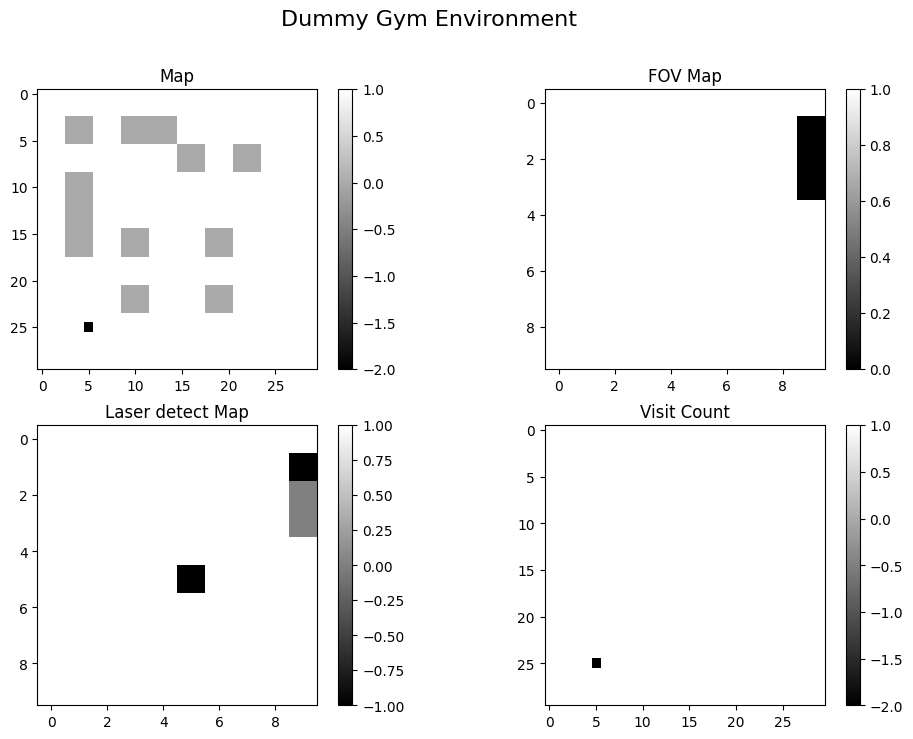

4
Car moves Up 3 units from (25, 5) to (22, 5)


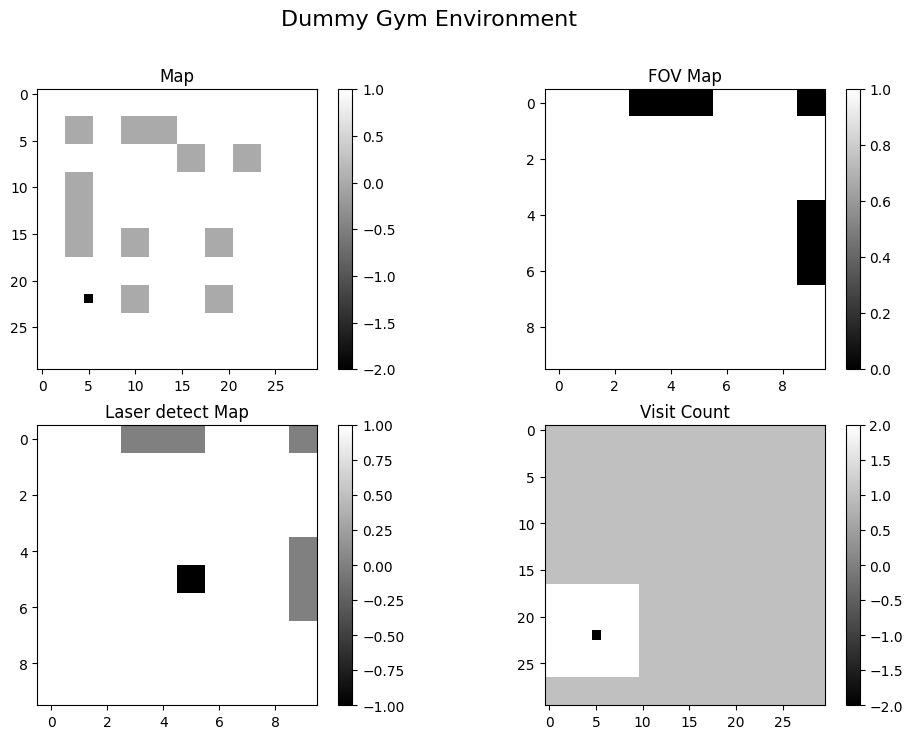

Car moves Left 3 units from (22, 5) to (22, 2)


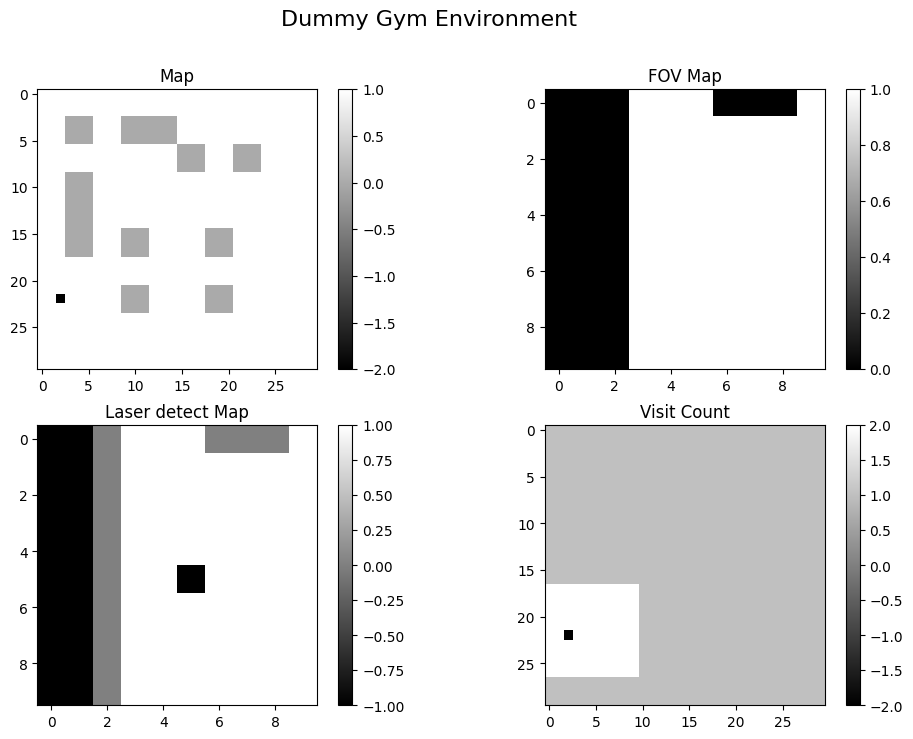

Car moves Down 3 units from (22, 2) to (25, 2)


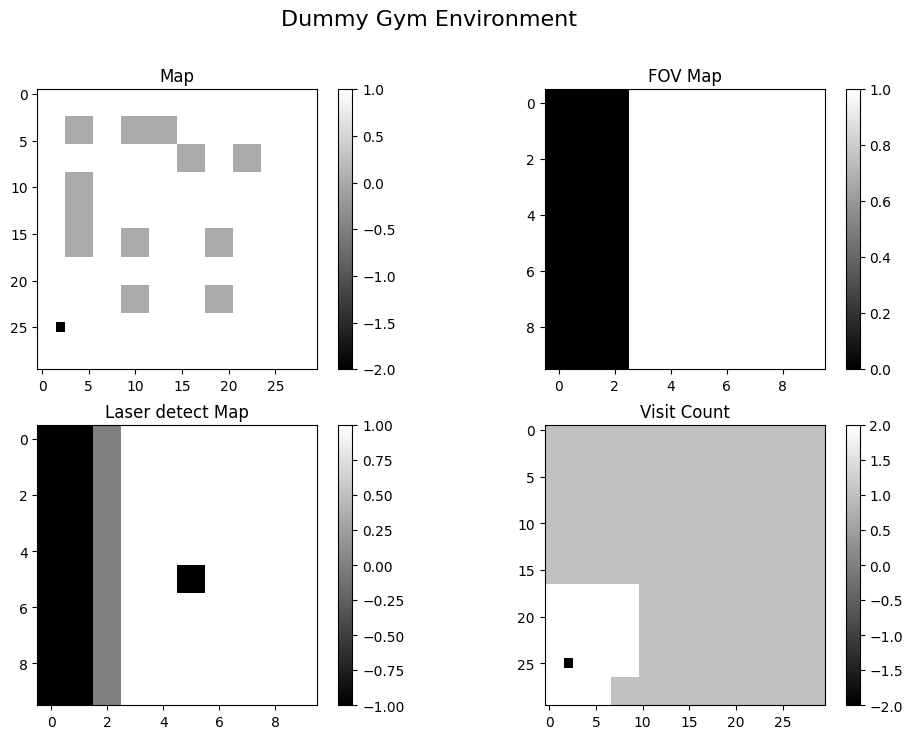

Car moves Right 3 units from (25, 2) to (25, 5)


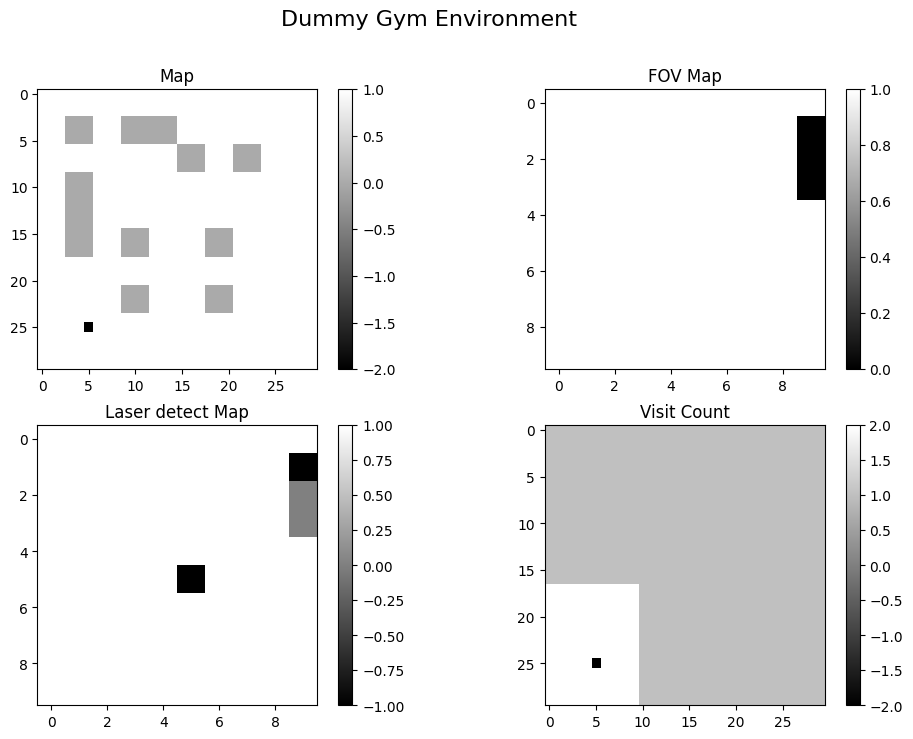

2024-11-16 12:04:12.094851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-11-16 12:04:12.094876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist


In [1]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym,EXPLORED
import pickle

# if there is a GPU available, set train the device to GPU
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Only I need to do this because I am running the code on my local machine
# os.chdir('/home/zhihan/ME5418')

# Create the environment instance
env = DummyGym()


## 1. Parameters setting
In order to test our model, we did not assign large parameters. Set the training mode using one of the following options:
### Training Mode Options
- **`train`**: Start training from scratch, overwriting existing model, state, and replay buffer files.
- **`test`**: Test the model without overwriting any files.
- **`train_from_breakpoint`**: Continue training from the last saved breakpoint.
- **`fine_tune`**: Fine-tune the model while preserving the previous model.

In [16]:
# 断点文件会保存在train_breakpoint文件夹中
# 如果中途训练中断，可以从断点处继续训练，只需将train_mode设置为'train_from_breakpoint'，包括模型文件、状态文件和replay_buffer文件
# 如果想重新训练，将train_mode设置为'train'即可，模型文件、状态文件和replay_buffer文件会被覆盖
# 如果想测试模型，将train_mode设置为'test'即可，模型文件、状态文件和replay_buffer文件不会被覆盖
# 如果既想重新训练，又想保留之前的模型，即微调模型，将train_mode设置为'fine_tune'即可

train_mode = 'fine_tune'
# train_mode = 'train' # 'train' or 'test' or 'train_from_breakpoint' or fine_tune
model_name = 'dqn_model.h5'
state_name = 'state.npz'
replay_buffer_name = 'replay_buffer.pkl'

breakpoint_path = 'train_breakpoint'
model_path = os.path.join(breakpoint_path, model_name)
state_path = os.path.join(breakpoint_path, state_name)
replay_buffer_path = os.path.join(breakpoint_path, replay_buffer_name)

# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 32 # 每次训练的数据量
n_episodes = 50 # 地图数量
time_steps = 300 # 每张地图最多走多少步，避免陷入局部重复导致训练无效数据
epochs = 10 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate, 0.99 means the future rewards are considered important
epsilon = 0.9 # 探索率
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((1, *map.shape, 1))` to reshape the state to 4 dimensions

In [8]:
# 处理原始state
def prepare_state(original_state):
    '''
    Prepare the state for the model by numpying and adding dimension
    '''
    new_state = []
    new_state_shape = []
    for state in original_state:
        state = np.array(state)
        # add dimension
        state = state.reshape(1, *state.shape, 1) # (30, 30) -> (1, 30, 30, 1)
        new_state.append(state)
        new_state_shape.append(state.shape)

    return new_state, new_state_shape

In [4]:
state, state_shape = prepare_state(original_state)
state_shape[0][1:]

(30, 30, 1)

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
**Model is loaded from `model_path` instead of being created if `train_mode` is set `fine_tune` or `train_from_breakpoint`**

In [15]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), activation='sigmoid', 
                     dense_units_1=64, dense_units_2=32, pool_size=(2,2), padding='same',
                     pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None, LSTM=False, flat=True, dense_twice=True): # 多一个全连接多2000参数
                                                                                                                                           # 如果flat=False参数直接减少183万，但会丢失空间信息，因为GlobalAveragePooling2D会平均所有值
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0][1:], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding=padding)(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1][1:], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding=padding)(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state) if flat == True else tf.keras.layers.GlobalAveragePooling2D()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2][1:], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Add LSTM layer for sequential processing
    lstm_layer = tf.keras.layers.Reshape((1, combined.shape[1]))(combined)  # Reshape for LSTM input
    lstm_layer = tf.keras.layers.LSTM(64, activation=activation)(lstm_layer)  # LSTM layer added

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation=activation, kernel_regularizer=regularizer)(lstm_layer if LSTM else combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation=activation, kernel_regularizer=regularizer)(dense1) if dense_twice else dense1
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
if train_mode == 'train_from_breakpoint' or train_mode == 'fine_tune' or train_mode == 'test':
    model = tf.keras.models.load_model(model_path)
    target_model = tf.keras.models.load_model(model_path)
elif train_mode == 'train':
    model = create_dqn_model()
    target_model = create_dqn_model()
    target_model.set_weights(model.get_weights())
else:
    raise ValueError('train_mode should be either train, test, fine_tune or train_from_breakpoint')
model.summary()

2024-11-16 12:04:12.149657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 10, 10, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 10, 10, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 10, 10, 16)   160         ['input_fov_map[0][0]']      

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [4]:
def select_action(state, epsilon, CHANGE_ACTION_FLAG):
    '''
    Select action using epsilon-greedy policy
    '''
    if np.random.rand() <= epsilon:
        action = random.randrange(action_size)  # Explore: random action
        print(f'Ready to take random action:{action}')
    else:
        env.render(map_type="visit_count")
        q_values = model.predict(state)  # Exploit: select action with max Q-value
        action_list = np.argsort(q_values[0])[::-1]
        action = action_list[CHANGE_ACTION_FLAG] if train_mode == 'test' else action_list[0]
        print(f'Ready to take action:{action} with q_values:{q_values} after {CHANGE_ACTION_FLAG} changes')
    
    return action  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target_model}}(\text{next_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [7]:
def train_dqn(batch_size): # learning agent
    with tf.device(device):
        minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
        for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据,32*avg_loss_decrease=64
            target = reward + gamma * np.amax(target_model.predict(next_state,verbose=0)[0])# 当前状态的reward作为target
            target_q_values = target_model.predict(state,verbose=0) # 得到4个动作的Q值
            target_q_values[0][action] = target # 将对应动作的Q值更新为target
            
            history = model.fit(state, target_q_values, epochs=epochs, verbose=0) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条

        # Update target model weights
        target_model.set_weights(model.get_weights())


## 6. Start tranning!
1. **Define saving and loading breakpoint function**:
   - In case of emergency like sudden death of kernel, function of saving and recovery should be defined.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.

In [8]:
def save_breakpoint():
    model.save(model_path)
    env.save_state(state_path)
    with open(replay_buffer_path, 'wb') as f:
        pickle.dump(replay_buffer, f)

def load_breakpoint():
    # Model already loaded
    with open(replay_buffer_path, 'rb') as f:
        replay_buffer = pickle.load(f)
    env.load_state(state_path)
    return replay_buffer

if train_mode=='train_from_breakpoint':
    replay_buffer = load_breakpoint()
    print('Loading model and replay buffer from breakpoint')
    env.render(map_type='visit_count')


********************Episode: 1/50********************

-------------------Time step: 0------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 5) to (22, 5)
Cells visited: 0/900 at time step: 0
Still adding data to replay buffer. Current replay buffer length: 1

-------------------Time step: 1------------------------
Ready to take random action:0
Car moves Up 3 units from (22, 5) to (19, 5)
Cells visited: 100/900 at time step: 1
Still adding data to replay buffer. Current replay buffer length: 2

-------------------Time step: 2------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (19, 5)
Cells visited: 130/900 at time step: 2
Still adding data to replay buffer. Current replay buffer length: 3

-------------------Time step: 3------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 5) to (19, 8)
Cells visited: 130/900 at time step: 3
Still adding data to replay buffer. Current repla

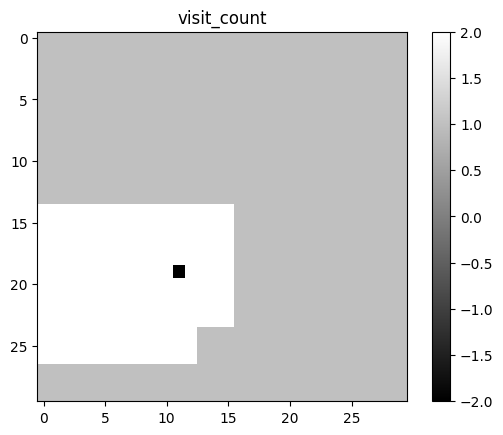

1/1 [==============================] - 0s 96ms/step
Ready to take action:3 with q_values:[[52.89787  51.127937 52.01182  53.978928]] after 2 changes
Car moves Right 3 units from (19, 11) to (19, 14)
Cells visited: 199/900 at time step: 10
Still adding data to replay buffer. Current replay buffer length: 11

-------------------Time step: 11------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 14) to (16, 14)
Cells visited: 229/900 at time step: 11
Still adding data to replay buffer. Current replay buffer length: 12

-------------------Time step: 12------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 14) to (13, 14)
Cells visited: 259/900 at time step: 12
Still adding data to replay buffer. Current replay buffer length: 13

-------------------Time step: 13------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 14) to (13, 11)
Cells visited: 289/900 at time step: 13
Still adding data to replay

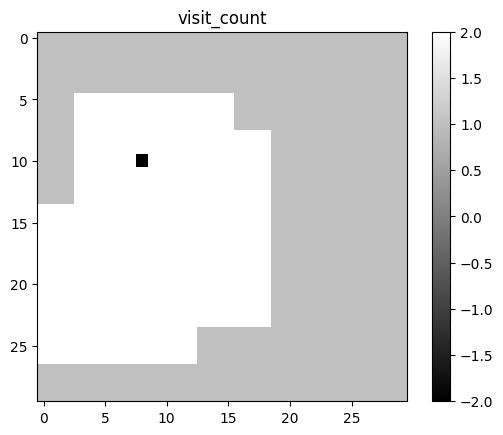

1/1 [==============================] - 0s 15ms/step
Ready to take action:3 with q_values:[[52.89787  51.127937 52.01182  53.978928]] after 0 changes
Car moves Right 3 units from (10, 8) to (10, 11)
Cells visited: 364/900 at time step: 16
Still adding data to replay buffer. Current replay buffer length: 17

-------------------Time step: 17------------------------


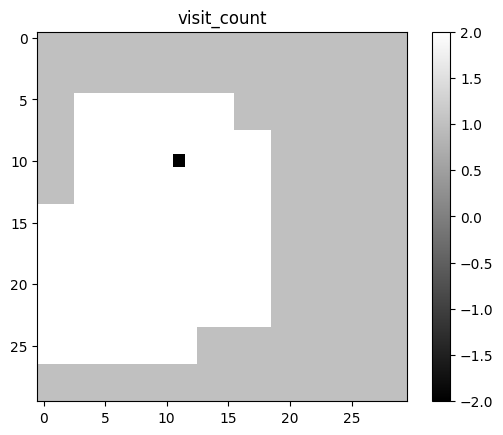

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[52.89787  51.127937 52.01182  53.978928]] after 0 changes
Car moves Right 3 units from (10, 11) to (10, 14)
Cells visited: 364/900 at time step: 17
Still adding data to replay buffer. Current replay buffer length: 18

-------------------Time step: 18------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 14) to (13, 14)
Cells visited: 373/900 at time step: 18
Still adding data to replay buffer. Current replay buffer length: 19

-------------------Time step: 19------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 14) to (10, 14)
Cells visited: 373/900 at time step: 19
Still adding data to replay buffer. Current replay buffer length: 20

-------------------Time step: 20------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 14) to (10, 11)
Cells visited: 373/900 at time step: 20
Still adding data to repl

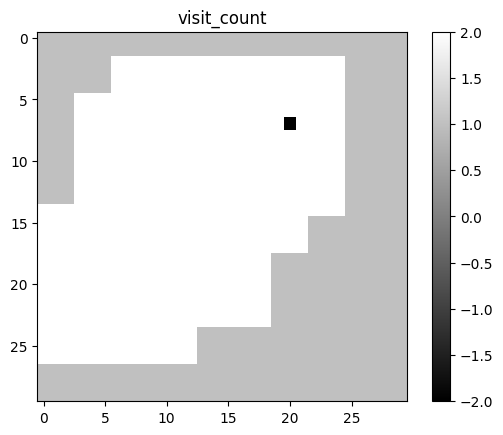

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[55.56343 53.03531 53.92962 54.46893]] after 1 changes
Car moves Up 3 units from (7, 20) to (4, 20)
Cells visited: 499/900 at time step: 41
Start training DQN model with batch size: 32

-------------------Time step: 42------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 20) to (1, 20)
Cells visited: 519/900 at time step: 42
Start training DQN model with batch size: 32

-------------------Time step: 43------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 20) to (1, 17)
Cells visited: 519/900 at time step: 43
Start training DQN model with batch size: 32

-------------------Time step: 44------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 17) to (1, 20)
Cells visited: 525/900 at time step: 44
Start training DQN model with batch size: 32

-------------------Time step: 45------------------------
Ready to

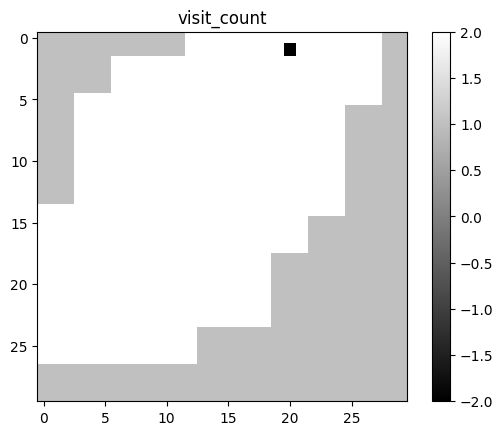

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[55.402332 54.940804 54.58887  55.524208]] after 0 changes
Car moves Right 3 units from (1, 20) to (1, 23)
Cells visited: 543/900 at time step: 48
Start training DQN model with batch size: 32

-------------------Time step: 49------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 543/900 at time step: 49
Start training DQN model with batch size: 32

-------------------Time step: 50------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 20) to (4, 20)
Cells visited: 543/900 at time step: 50
Start training DQN model with batch size: 32


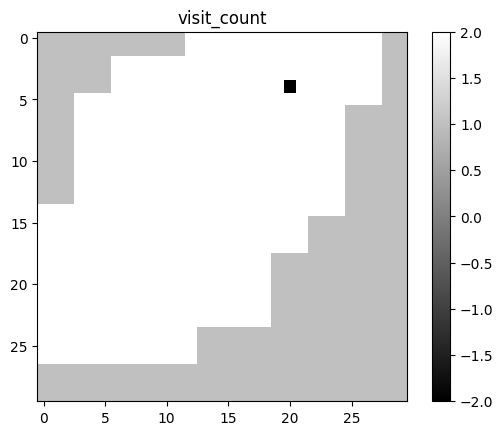

Model and replay buffer are saved under train_breakpoint at time step: 50

-------------------Time step: 51------------------------


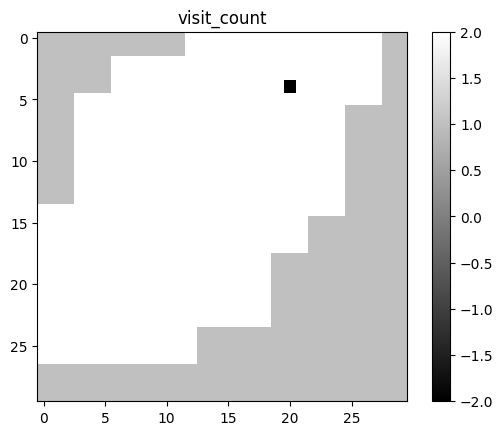

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[55.8391  55.02404 54.7519  55.90102]] after 0 changes
Car moves Right 3 units from (4, 20) to (4, 23)
Cells visited: 543/900 at time step: 51
Start training DQN model with batch size: 32

-------------------Time step: 52------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 23) to (4, 26)
Cells visited: 552/900 at time step: 52
Start training DQN model with batch size: 32

-------------------Time step: 53------------------------
Ready to take random action:2
Car moves Left 3 units from (4, 26) to (4, 23)
Cells visited: 570/900 at time step: 53
Start training DQN model with batch size: 32

-------------------Time step: 54------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 23) to (4, 26)
Cells visited: 570/900 at time step: 54
Start training DQN model with batch size: 32

-------------------Time step: 55------------------------
Re

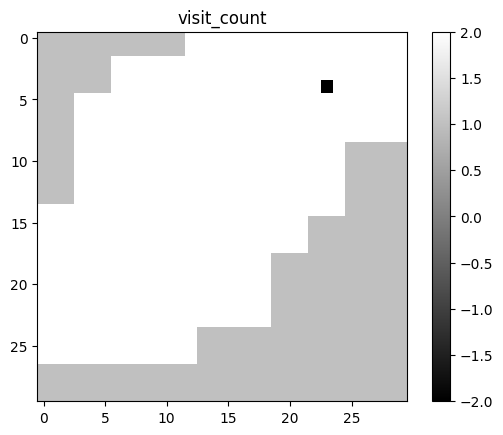

1/1 [==============================] - 0s 13ms/step
Ready to take action:2 with q_values:[[55.012085 55.062366 56.394817 56.338093]] after 0 changes
Car moves Left 3 units from (4, 23) to (4, 20)
Cells visited: 570/900 at time step: 58
Start training DQN model with batch size: 32

-------------------Time step: 59------------------------
Ready to take random action:1
Car moves Down 3 units from (4, 20) to (7, 20)
Cells visited: 570/900 at time step: 59
Start training DQN model with batch size: 32

-------------------Time step: 60------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 20) to (10, 20)
Cells visited: 570/900 at time step: 60
Start training DQN model with batch size: 32

-------------------Time step: 61------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 20) to (10, 23)
Cells visited: 570/900 at time step: 61
Start training DQN model with batch size: 32

-------------------Time step: 62----------------------

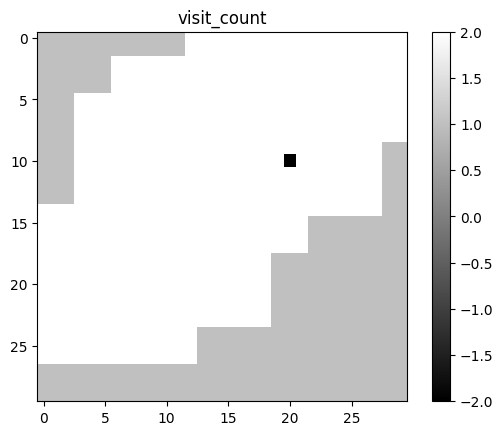

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[55.970364 55.99044  56.47711  57.010117]] after 0 changes
Car moves Right 3 units from (10, 20) to (10, 23)
Cells visited: 588/900 at time step: 65
Start training DQN model with batch size: 32

-------------------Time step: 66------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 23)
Cells visited: 588/900 at time step: 66
Start training DQN model with batch size: 32

-------------------Time step: 67------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 23)
Cells visited: 588/900 at time step: 67
Start training DQN model with batch size: 32

-------------------Time step: 68------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 23) to (13, 23)
Cells visited: 588/900 at time step: 68
Start training DQN model with batch size: 32

-------------------Time step: 69---------

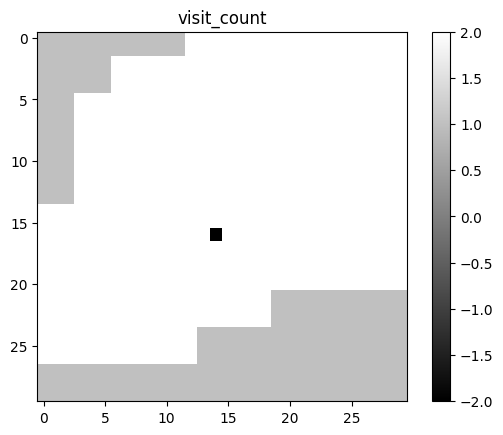

1/1 [==============================] - 0s 16ms/step
Ready to take action:1 with q_values:[[56.581585 57.917698 57.168224 57.396904]] after 0 changes
Car moves Down 3 units from (16, 14) to (19, 14)
Cells visited: 657/900 at time step: 87
Start training DQN model with batch size: 32

-------------------Time step: 88------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 14) to (16, 14)
Cells visited: 657/900 at time step: 88
Start training DQN model with batch size: 32

-------------------Time step: 89------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (16, 14)
Cells visited: 657/900 at time step: 89
Start training DQN model with batch size: 32

-------------------Time step: 90------------------------
Ready to take random action:1
Car moves Down 3 units from (16, 14) to (19, 14)
Cells visited: 657/900 at time step: 90
Start training DQN model with batch size: 32

-------------------Time step: 91----------------

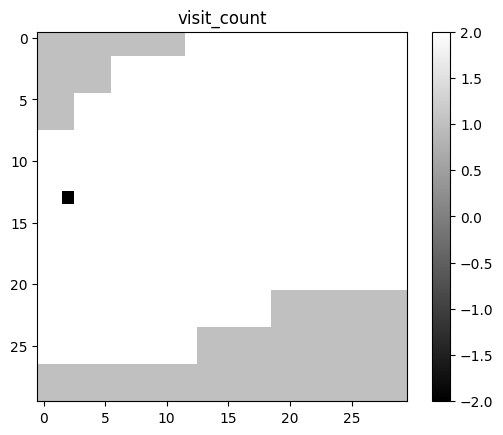

Model and replay buffer are saved under train_breakpoint at time step: 100

-------------------Time step: 101------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 101
Start training DQN model with batch size: 32

-------------------Time step: 102------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 102
Start training DQN model with batch size: 32

-------------------Time step: 103------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 103
Start training DQN model with batch size: 32

-------------------Time step: 104------------------------


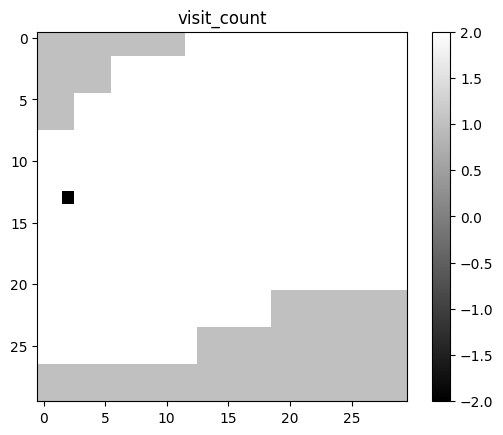

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[54.877857 57.32298  56.683952 57.964527]] after 3 changes
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 104
Start training DQN model with batch size: 32

-------------------Time step: 105------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 105
Start training DQN model with batch size: 32

-------------------Time step: 106------------------------


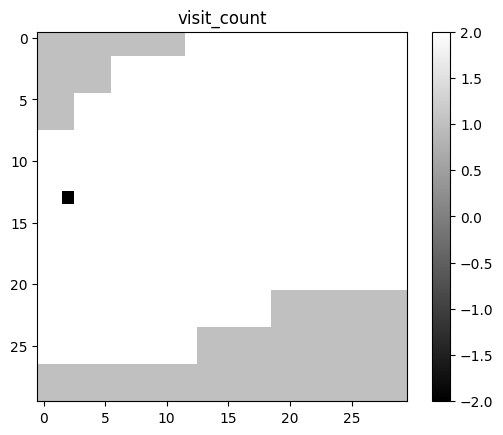

1/1 [==============================] - 0s 13ms/step
Ready to take action:3 with q_values:[[54.71453  57.29201  57.006912 57.97003 ]] after 5 changes
Collision! Car stays in the same position:  (13, 2)
Cells visited: 675/900 at time step: 106
Start training DQN model with batch size: 32

-------------------Time step: 107------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 2) to (10, 2)
Cells visited: 675/900 at time step: 107
Start training DQN model with batch size: 32

-------------------Time step: 108------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (10, 2)
Cells visited: 684/900 at time step: 108
Start training DQN model with batch size: 32

-------------------Time step: 109------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 2) to (13, 2)
Cells visited: 684/900 at time step: 109
Start training DQN model with batch size: 32

-------------------Time step: 110----------

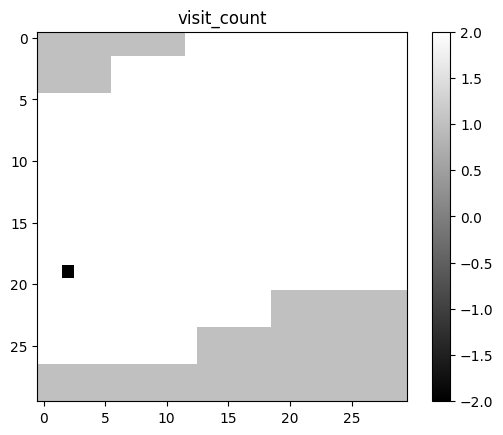

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[57.92783  57.71793  55.59279  55.581818]] after 0 changes
Car moves Up 3 units from (19, 2) to (16, 2)
Cells visited: 684/900 at time step: 115
Start training DQN model with batch size: 32

-------------------Time step: 116------------------------
Ready to take random action:1
Car moves Down 3 units from (16, 2) to (19, 2)
Cells visited: 684/900 at time step: 116
Start training DQN model with batch size: 32

-------------------Time step: 117------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 2) to (16, 2)
Cells visited: 684/900 at time step: 117
Start training DQN model with batch size: 32

-------------------Time step: 118------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 2) to (13, 2)
Cells visited: 684/900 at time step: 118
Start training DQN model with batch size: 32

-------------------Time step: 119------------------------

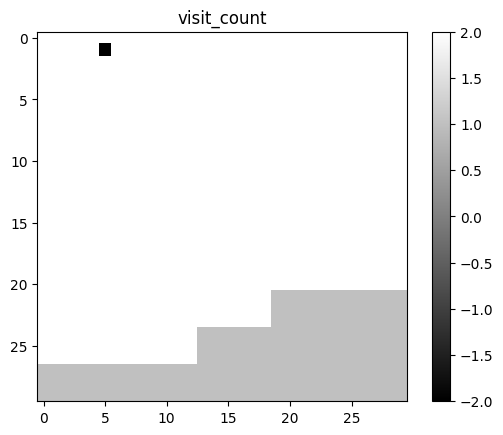

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[58.601948 58.6545   55.71623  55.199654]] after 0 changes
Collision! Car stays in the same position:  (1, 5)
Cells visited: 726/900 at time step: 147
Start training DQN model with batch size: 32

-------------------Time step: 148------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 5)
Cells visited: 726/900 at time step: 148
Start training DQN model with batch size: 32

-------------------Time step: 149------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 5)
Cells visited: 726/900 at time step: 149
Start training DQN model with batch size: 32

-------------------Time step: 150------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 5)
Cells visited: 726/900 at time step: 150
Start training DQN model with batch size: 32


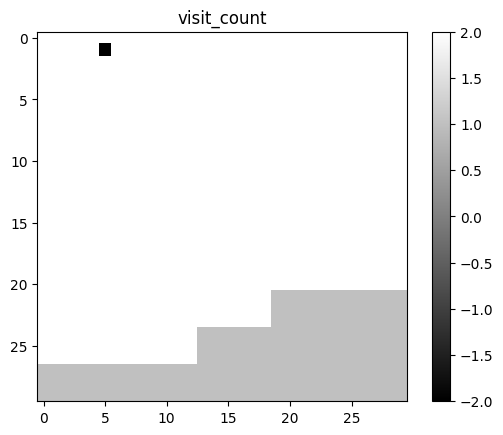

Model and replay buffer are saved under train_breakpoint at time step: 150

-------------------Time step: 151------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 5) to (1, 2)
Cells visited: 726/900 at time step: 151
Start training DQN model with batch size: 32

-------------------Time step: 152------------------------


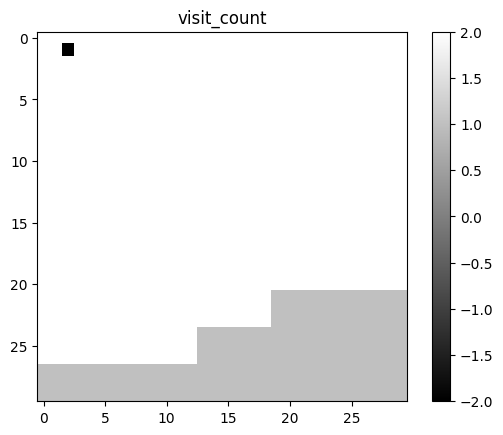

1/1 [==============================] - 0s 14ms/step
Ready to take action:1 with q_values:[[57.56505  58.22502  57.025127 56.208904]] after 0 changes
Car moves Down 3 units from (1, 2) to (4, 2)
Cells visited: 726/900 at time step: 152
Start training DQN model with batch size: 32

-------------------Time step: 153------------------------
Ready to take random action:1
Car moves Down 3 units from (4, 2) to (7, 2)
Cells visited: 726/900 at time step: 153
Start training DQN model with batch size: 32

-------------------Time step: 154------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 2) to (10, 2)
Cells visited: 726/900 at time step: 154
Start training DQN model with batch size: 32

-------------------Time step: 155------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (10, 2)
Cells visited: 726/900 at time step: 155
Start training DQN model with batch size: 32

-------------------Time step: 156------------------

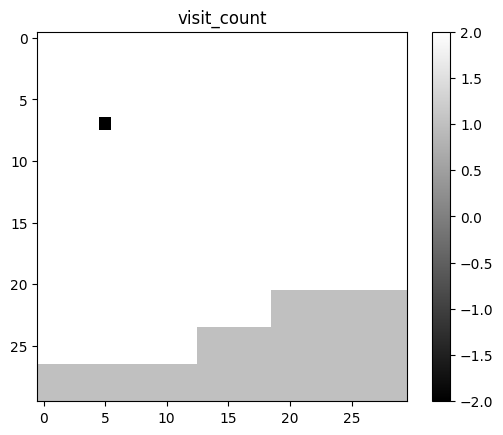

1/1 [==============================] - 0s 18ms/step
Ready to take action:1 with q_values:[[54.7999   56.68113  55.407787 55.602627]] after 1 changes
Collision! Car stays in the same position:  (7, 5)
Cells visited: 726/900 at time step: 172
Start training DQN model with batch size: 32

-------------------Time step: 173------------------------
Ready to take random action:3
Car moves Right 3 units from (7, 5) to (7, 8)
Cells visited: 726/900 at time step: 173
Start training DQN model with batch size: 32

-------------------Time step: 174------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 8) to (10, 8)
Cells visited: 726/900 at time step: 174
Start training DQN model with batch size: 32

-------------------Time step: 175------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 8) to (13, 8)
Cells visited: 726/900 at time step: 175
Start training DQN model with batch size: 32

-------------------Time step: 176----------------

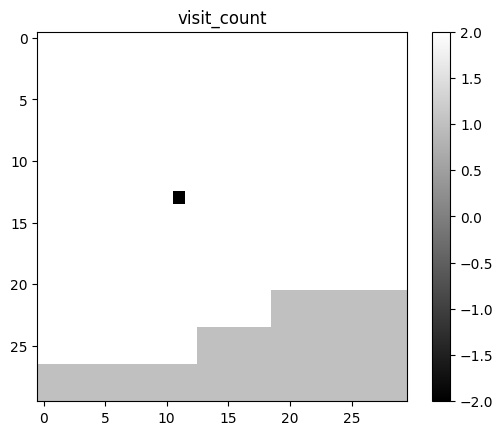

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[54.810593 55.94626  54.71532  54.51885 ]] after 0 changes
Collision! Car stays in the same position:  (13, 11)
Cells visited: 726/900 at time step: 180
Start training DQN model with batch size: 32

-------------------Time step: 181------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (13, 11)
Cells visited: 726/900 at time step: 181
Start training DQN model with batch size: 32

-------------------Time step: 182------------------------
Ready to take random action:3
Car moves Right 3 units from (13, 11) to (13, 14)
Cells visited: 726/900 at time step: 182
Start training DQN model with batch size: 32

-------------------Time step: 183------------------------
Ready to take random action:2
Car moves Left 3 units from (13, 14) to (13, 11)
Cells visited: 726/900 at time step: 183
Start training DQN model with batch size: 32

-------------------Time step: 184-

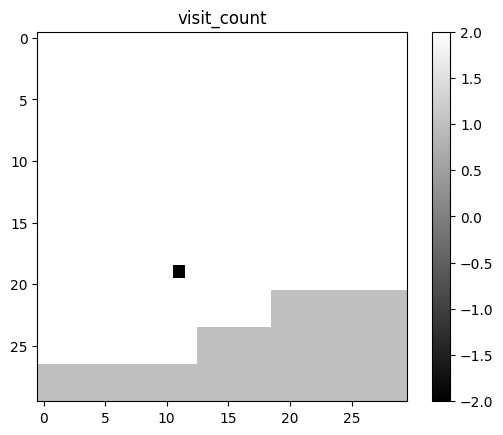

1/1 [==============================] - 0s 14ms/step
Ready to take action:1 with q_values:[[53.909462 54.156834 52.842224 52.67308 ]] after 0 changes
Collision! Car stays in the same position:  (19, 11)
Cells visited: 726/900 at time step: 192
Start training DQN model with batch size: 32

-------------------Time step: 193------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 11) to (19, 14)
Cells visited: 726/900 at time step: 193
Start training DQN model with batch size: 32

-------------------Time step: 194------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 14) to (19, 17)
Cells visited: 726/900 at time step: 194
Start training DQN model with batch size: 32

-------------------Time step: 195------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 17) to (19, 20)
Cells visited: 735/900 at time step: 195
Start training DQN model with batch size: 32

-------------------Time step: 196---

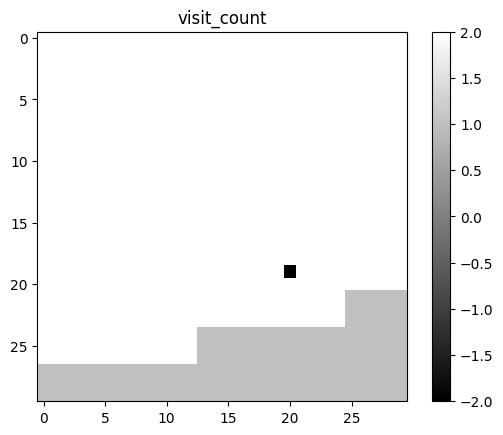

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[51.79834  52.087933 50.15694  51.029774]] after 2 changes
Collision! Car stays in the same position:  (19, 20)
Cells visited: 744/900 at time step: 198
Start training DQN model with batch size: 32

-------------------Time step: 199------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (19, 20)
Cells visited: 744/900 at time step: 199
Start training DQN model with batch size: 32

-------------------Time step: 200------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 20) to (19, 23)
Cells visited: 744/900 at time step: 200
Start training DQN model with batch size: 32


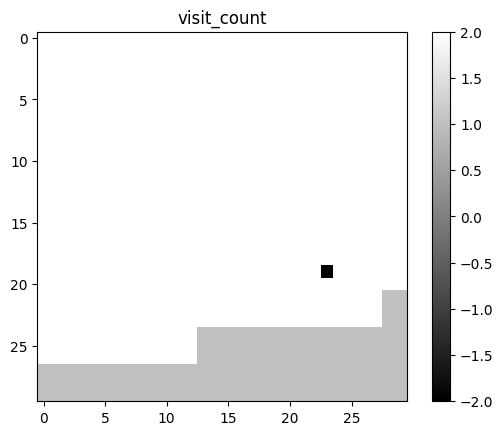

Model and replay buffer are saved under train_breakpoint at time step: 200

-------------------Time step: 201------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 23) to (16, 23)
Cells visited: 753/900 at time step: 201
Start training DQN model with batch size: 32

-------------------Time step: 202------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (16, 23)
Cells visited: 753/900 at time step: 202
Start training DQN model with batch size: 32

-------------------Time step: 203------------------------
Ready to take random action:3
Car moves Right 3 units from (16, 23) to (16, 26)
Cells visited: 753/900 at time step: 203
Start training DQN model with batch size: 32

-------------------Time step: 204------------------------
Ready to take random action:0
Car moves Up 3 units from (16, 26) to (13, 26)
Cells visited: 753/900 at time step: 204
Start training DQN model with batch size: 32

-------------------Time ste

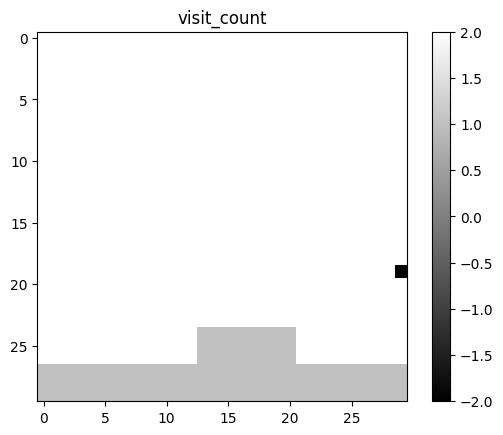

1/1 [==============================] - 0s 14ms/step
Ready to take action:1 with q_values:[[46.761066 48.756653 47.44046  47.973663]] after 2 changes
Car moves Down 3 units from (19, 29) to (22, 29)
Cells visited: 786/900 at time step: 214
Start training DQN model with batch size: 32

-------------------Time step: 215------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (22, 29)
Cells visited: 786/900 at time step: 215
Start training DQN model with batch size: 32

-------------------Time step: 216------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (22, 29)
Cells visited: 786/900 at time step: 216
Start training DQN model with batch size: 32

-------------------Time step: 217------------------------
Ready to take random action:1
Car moves Down 3 units from (22, 29) to (25, 29)
Cells visited: 786/900 at time step: 217
Start training DQN model with batch size: 32

-------------------Time step: 218--

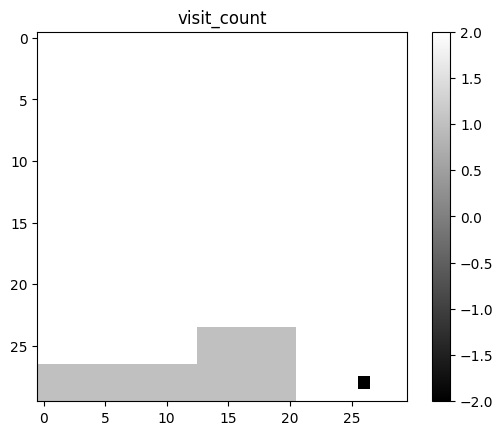

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[46.5994   47.28904  46.605827 46.834667]] after 1 changes
Collision! Car stays in the same position:  (28, 26)
Cells visited: 813/900 at time step: 221
Start training DQN model with batch size: 32

-------------------Time step: 222------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 26) to (28, 29)
Cells visited: 813/900 at time step: 222
Start training DQN model with batch size: 32

-------------------Time step: 223------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 29) to (25, 29)
Cells visited: 813/900 at time step: 223
Start training DQN model with batch size: 32

-------------------Time step: 224------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 29) to (22, 29)
Cells visited: 813/900 at time step: 224
Start training DQN model with batch size: 32

-------------------Time step: 225---------

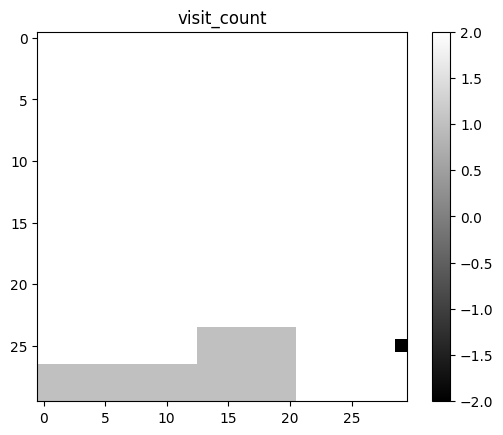

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[44.623077 44.810307 44.179203 44.386227]] after 0 changes
Car moves Down 3 units from (25, 29) to (28, 29)
Cells visited: 813/900 at time step: 226
Start training DQN model with batch size: 32

-------------------Time step: 227------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 29) to (28, 26)
Cells visited: 813/900 at time step: 227
Start training DQN model with batch size: 32

-------------------Time step: 228------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 26) to (28, 23)
Cells visited: 813/900 at time step: 228
Start training DQN model with batch size: 32

-------------------Time step: 229------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 23) to (28, 26)
Cells visited: 831/900 at time step: 229
Start training DQN model with batch size: 32

-------------------Time step: 230---------

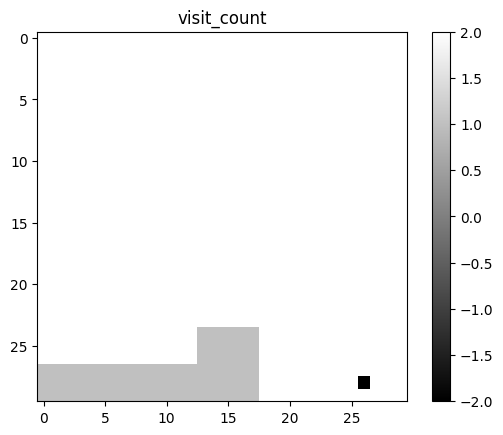

1/1 [==============================] - 0s 13ms/step
Ready to take action:1 with q_values:[[44.14061  44.357132 41.900394 42.903404]] after 0 changes
Collision! Car stays in the same position:  (28, 26)
Cells visited: 831/900 at time step: 233
Start training DQN model with batch size: 32

-------------------Time step: 234------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 26)
Cells visited: 831/900 at time step: 234
Start training DQN model with batch size: 32

-------------------Time step: 235------------------------
Ready to take random action:2
Car moves Left 3 units from (28, 26) to (28, 23)
Cells visited: 831/900 at time step: 235
Start training DQN model with batch size: 32

-------------------Time step: 236------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 23) to (25, 23)
Cells visited: 831/900 at time step: 236
Start training DQN model with batch size: 32

-------------------Time step: 237----

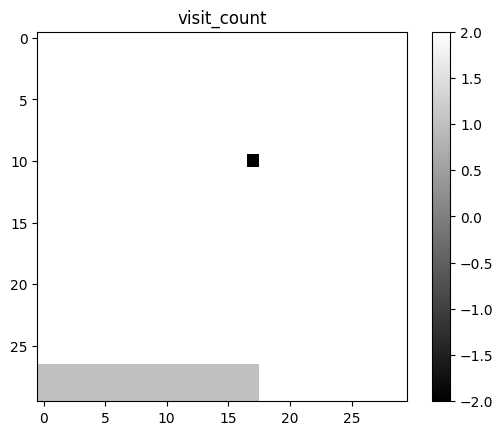

Model and replay buffer are saved under train_breakpoint at time step: 250

-------------------Time step: 251------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (10, 17)
Cells visited: 846/900 at time step: 251
Start training DQN model with batch size: 32

-------------------Time step: 252------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 17) to (10, 20)
Cells visited: 846/900 at time step: 252
Start training DQN model with batch size: 32

-------------------Time step: 253------------------------
Ready to take random action:0
Car moves Up 3 units from (10, 20) to (7, 20)
Cells visited: 846/900 at time step: 253
Start training DQN model with batch size: 32

-------------------Time step: 254------------------------
Ready to take random action:0
Car moves Up 3 units from (7, 20) to (4, 20)
Cells visited: 846/900 at time step: 254
Start training DQN model with batch size: 32

-------------------Time step: 

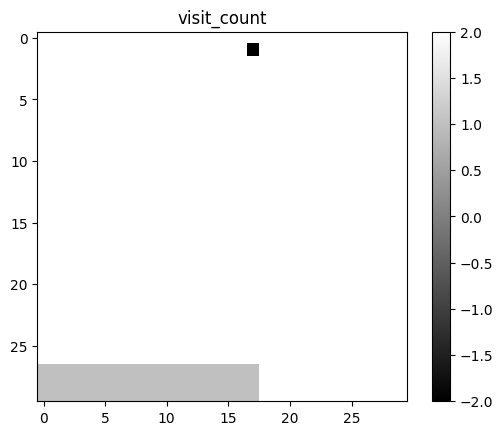

1/1 [==============================] - 0s 14ms/step
Ready to take action:2 with q_values:[[36.06093  35.813946 36.37788  35.348003]] after 0 changes
Car moves Left 3 units from (1, 17) to (1, 14)
Cells visited: 846/900 at time step: 258
Start training DQN model with batch size: 32

-------------------Time step: 259------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 14)
Cells visited: 846/900 at time step: 259
Start training DQN model with batch size: 32

-------------------Time step: 260------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 14) to (1, 11)
Cells visited: 846/900 at time step: 260
Start training DQN model with batch size: 32

-------------------Time step: 261------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 11) to (1, 14)
Cells visited: 846/900 at time step: 261
Start training DQN model with batch size: 32

-------------------Time step: 262------------

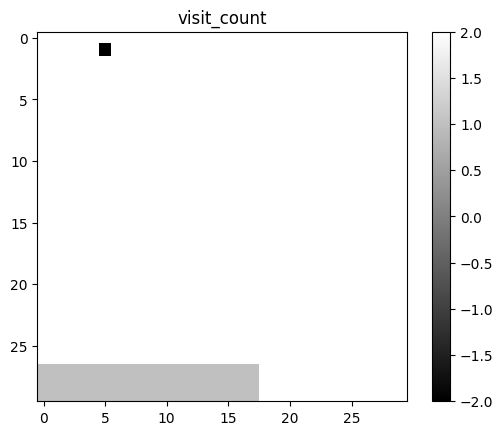

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[31.5172   31.085558 31.512888 31.903883]] after 0 changes
Car moves Right 3 units from (1, 5) to (1, 8)
Cells visited: 846/900 at time step: 274
Start training DQN model with batch size: 32

-------------------Time step: 275------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 8) to (1, 11)
Cells visited: 846/900 at time step: 275
Start training DQN model with batch size: 32

-------------------Time step: 276------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (1, 11)
Cells visited: 846/900 at time step: 276
Start training DQN model with batch size: 32

-------------------Time step: 277------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (1, 11)
Cells visited: 846/900 at time step: 277
Start training DQN model with batch size: 32

-------------------Time step: 278---------

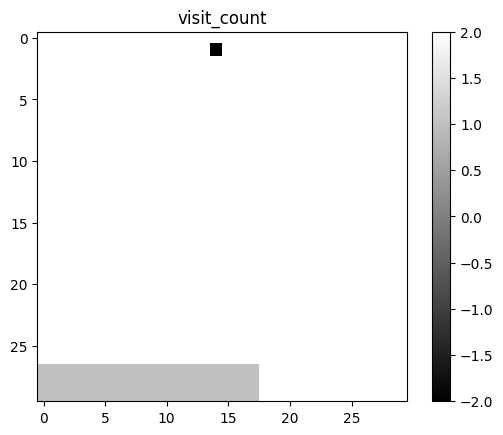

1/1 [==============================] - 0s 15ms/step
Ready to take action:3 with q_values:[[29.855612 29.572205 29.662868 29.996727]] after 1 changes
Car moves Right 3 units from (1, 14) to (1, 17)
Cells visited: 846/900 at time step: 283
Start training DQN model with batch size: 32

-------------------Time step: 284------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 17)
Cells visited: 846/900 at time step: 284
Start training DQN model with batch size: 32

-------------------Time step: 285------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 17) to (4, 17)
Cells visited: 846/900 at time step: 285
Start training DQN model with batch size: 32

-------------------Time step: 286------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 17) to (4, 20)
Cells visited: 846/900 at time step: 286
Start training DQN model with batch size: 32

-------------------Time step: 287-----------

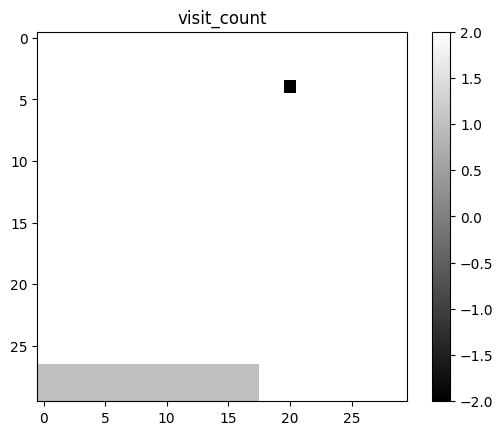

1/1 [==============================] - 0s 13ms/step
Ready to take action:3 with q_values:[[28.394646 28.79657  29.000683 29.335138]] after 0 changes
Car moves Right 3 units from (4, 20) to (4, 23)
Cells visited: 846/900 at time step: 287
Start training DQN model with batch size: 32

-------------------Time step: 288------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 23) to (1, 23)
Cells visited: 846/900 at time step: 288
Start training DQN model with batch size: 32

-------------------Time step: 289------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 846/900 at time step: 289
Start training DQN model with batch size: 32

-------------------Time step: 290------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 20)
Cells visited: 846/900 at time step: 290
Start training DQN model with batch size: 32

-------------------Time step: 291--------------

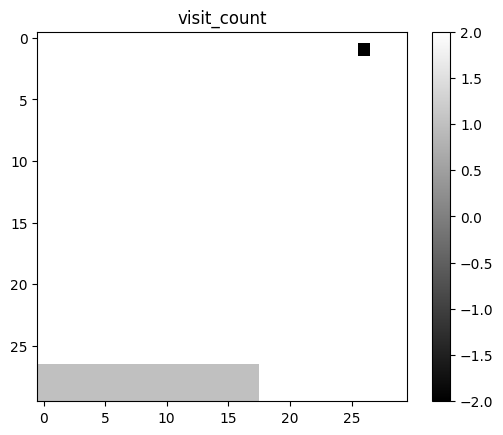

1/1 [==============================] - 0s 17ms/step
Ready to take action:0 with q_values:[[28.550543 26.797686 26.613974 27.82941 ]] after 0 changes
Collision! Car stays in the same position:  (1, 26)
Cells visited: 846/900 at time step: 299
Start training DQN model with batch size: 32

********************Episode: 2/50********************

-------------------Time step: 0------------------------
Ready to take random action:0
Car moves Up 3 units from (25, 5) to (22, 5)
Cells visited: 0/900 at time step: 0
Still adding data to replay buffer. Current replay buffer length: 1

-------------------Time step: 1------------------------
Ready to take random action:3
Car moves Right 3 units from (22, 5) to (22, 8)
Cells visited: 100/900 at time step: 1
Still adding data to replay buffer. Current replay buffer length: 2

-------------------Time step: 2------------------------
Ready to take random action:0
Car moves Up 3 units from (22, 8) to (19, 8)
Cells visited: 130/900 at time step: 2
Still ad

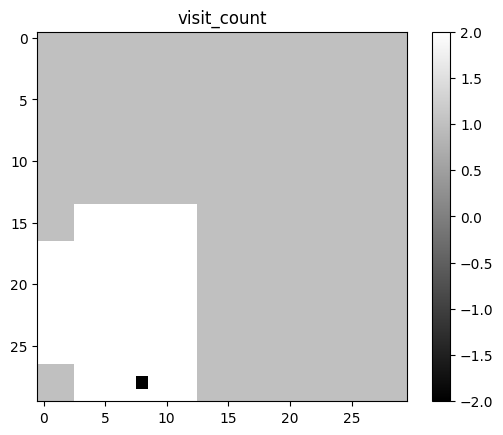

1/1 [==============================] - 0s 15ms/step
Ready to take action:0 with q_values:[[28.138859 26.79551  26.75251  26.637281]] after 0 changes
Car moves Up 3 units from (28, 8) to (25, 8)
Cells visited: 190/900 at time step: 10
Still adding data to replay buffer. Current replay buffer length: 11

-------------------Time step: 11------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 8) to (28, 8)
Cells visited: 190/900 at time step: 11
Still adding data to replay buffer. Current replay buffer length: 12

-------------------Time step: 12------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 8)
Cells visited: 190/900 at time step: 12
Still adding data to replay buffer. Current replay buffer length: 13

-------------------Time step: 13------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 8) to (25, 8)
Cells visited: 190/900 at time step: 13
Still adding data to replay buf

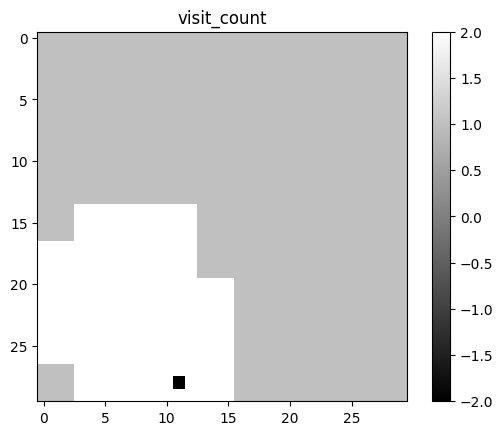

1/1 [==============================] - 0s 16ms/step
Ready to take action:0 with q_values:[[28.138859 26.79551  26.75251  26.637281]] after 1 changes
Car moves Up 3 units from (28, 11) to (25, 11)
Cells visited: 220/900 at time step: 19
Still adding data to replay buffer. Current replay buffer length: 20

-------------------Time step: 20------------------------
Ready to take random action:3
Car moves Right 3 units from (25, 11) to (25, 14)
Cells visited: 220/900 at time step: 20
Still adding data to replay buffer. Current replay buffer length: 21

-------------------Time step: 21------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 14) to (25, 11)
Cells visited: 250/900 at time step: 21
Still adding data to replay buffer. Current replay buffer length: 22

-------------------Time step: 22------------------------
Ready to take random action:3
Car moves Right 3 units from (25, 11) to (25, 14)
Cells visited: 250/900 at time step: 22
Still adding data to rep

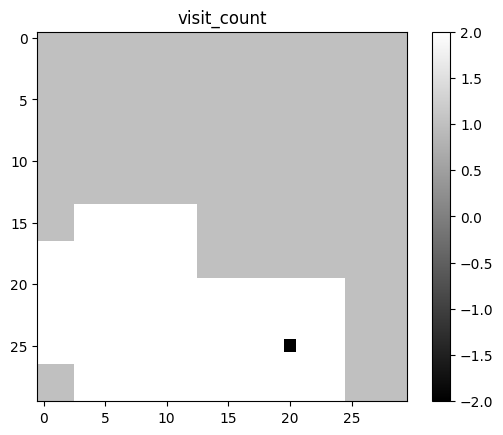

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[31.84906  28.555092 27.965818 30.425545]] after 0 changes
Collision! Car stays in the same position:  (25, 20)
Cells visited: 310/900 at time step: 39
Start training DQN model with batch size: 32

-------------------Time step: 40------------------------


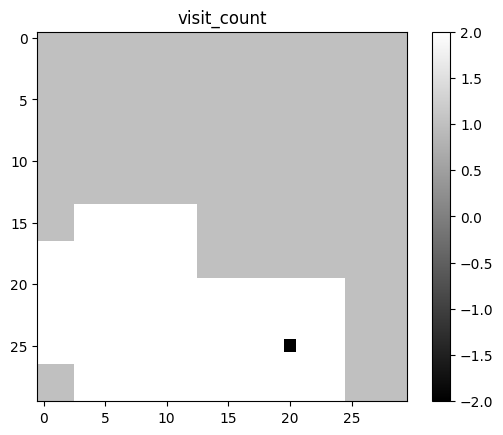

1/1 [==============================] - 0s 13ms/step
Ready to take action:0 with q_values:[[32.152172 29.255661 27.965736 31.12169 ]] after 1 changes
Collision! Car stays in the same position:  (25, 20)
Cells visited: 310/900 at time step: 40
Start training DQN model with batch size: 32

-------------------Time step: 41------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 20) to (25, 17)
Cells visited: 310/900 at time step: 41
Start training DQN model with batch size: 32

-------------------Time step: 42------------------------
Ready to take random action:3
Car moves Right 3 units from (25, 17) to (25, 20)
Cells visited: 310/900 at time step: 42
Start training DQN model with batch size: 32

-------------------Time step: 43------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 20) to (28, 20)
Cells visited: 310/900 at time step: 43
Start training DQN model with batch size: 32

-------------------Time step: 44-------------

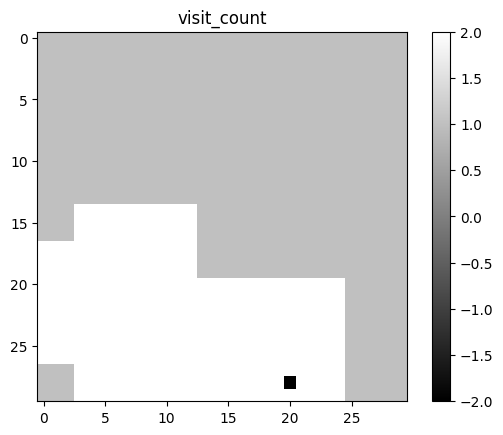

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[32.704983 31.098726 30.147383 31.95716 ]] after 1 changes
Car moves Up 3 units from (28, 20) to (25, 20)
Cells visited: 310/900 at time step: 45
Start training DQN model with batch size: 32

-------------------Time step: 46------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 20) to (25, 17)
Cells visited: 310/900 at time step: 46
Start training DQN model with batch size: 32

-------------------Time step: 47------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 17) to (25, 14)
Cells visited: 310/900 at time step: 47
Start training DQN model with batch size: 32

-------------------Time step: 48------------------------
Ready to take random action:2
Car moves Left 3 units from (25, 14) to (25, 11)
Cells visited: 310/900 at time step: 48
Start training DQN model with batch size: 32

-------------------Time step: 49--------------------

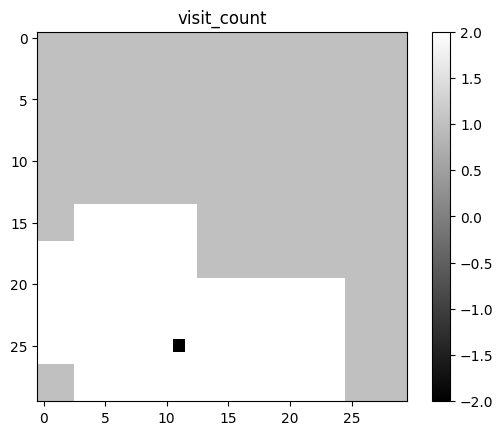

Model and replay buffer are saved under train_breakpoint at time step: 50

-------------------Time step: 51------------------------
Ready to take random action:1
Car moves Down 3 units from (25, 11) to (28, 11)
Cells visited: 310/900 at time step: 51
Start training DQN model with batch size: 32

-------------------Time step: 52------------------------


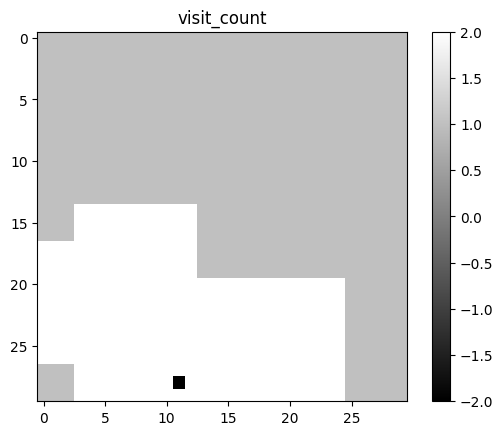

1/1 [==============================] - 0s 15ms/step
Ready to take action:3 with q_values:[[32.694656 31.438389 32.42098  33.355423]] after 0 changes
Car moves Right 3 units from (28, 11) to (28, 14)
Cells visited: 310/900 at time step: 52
Start training DQN model with batch size: 32

-------------------Time step: 53------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (28, 14)
Cells visited: 310/900 at time step: 53
Start training DQN model with batch size: 32

-------------------Time step: 54------------------------


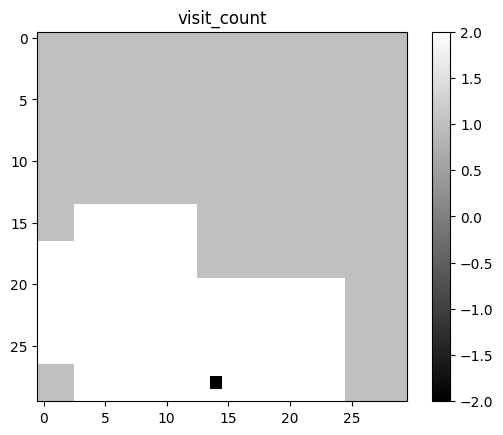

1/1 [==============================] - 0s 15ms/step
Ready to take action:3 with q_values:[[33.89687  30.965294 32.391285 34.05721 ]] after 1 changes
Car moves Right 3 units from (28, 14) to (28, 17)
Cells visited: 310/900 at time step: 54
Start training DQN model with batch size: 32

-------------------Time step: 55------------------------
Ready to take random action:3
Car moves Right 3 units from (28, 17) to (28, 20)
Cells visited: 310/900 at time step: 55
Start training DQN model with batch size: 32

-------------------Time step: 56------------------------
Ready to take random action:0
Car moves Up 3 units from (28, 20) to (25, 20)
Cells visited: 310/900 at time step: 56
Start training DQN model with batch size: 32

-------------------Time step: 57------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (25, 20)
Cells visited: 310/900 at time step: 57
Start training DQN model with batch size: 32

-------------------Time step: 58--------------

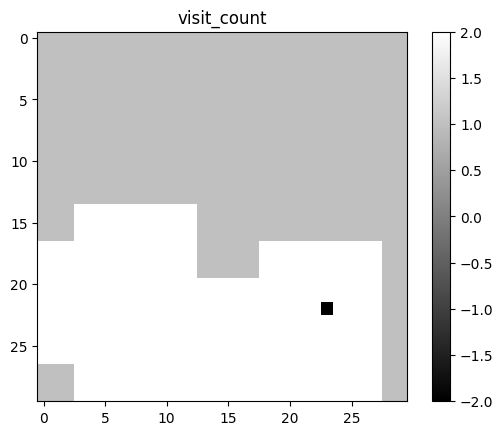

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[34.505657 33.30856  33.8776   35.137062]] after 0 changes
Car moves Right 3 units from (22, 23) to (22, 26)
Cells visited: 370/900 at time step: 60
Start training DQN model with batch size: 32

-------------------Time step: 61------------------------
Ready to take random action:2
Car moves Left 3 units from (22, 26) to (22, 23)
Cells visited: 390/900 at time step: 61
Start training DQN model with batch size: 32

-------------------Time step: 62------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (22, 23)
Cells visited: 390/900 at time step: 62
Start training DQN model with batch size: 32

-------------------Time step: 63------------------------
Ready to take random action:0
Car moves Up 3 units from (22, 23) to (19, 23)
Cells visited: 390/900 at time step: 63
Start training DQN model with batch size: 32

-------------------Time step: 64---------------

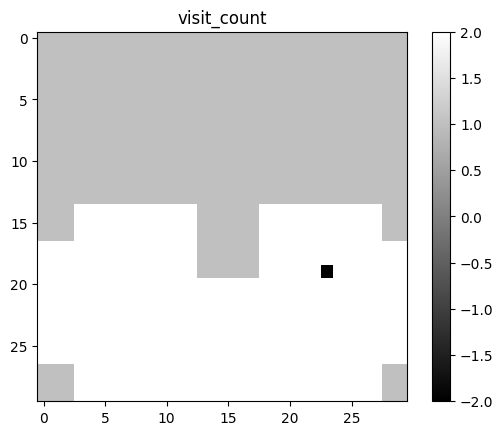

1/1 [==============================] - 0s 18ms/step
Ready to take action:3 with q_values:[[35.232674 34.43897  34.23733  36.09189 ]] after 0 changes
Car moves Right 3 units from (19, 23) to (19, 26)
Cells visited: 420/900 at time step: 64
Start training DQN model with batch size: 32

-------------------Time step: 65------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 26) to (19, 29)
Cells visited: 426/900 at time step: 65
Start training DQN model with batch size: 32

-------------------Time step: 66------------------------


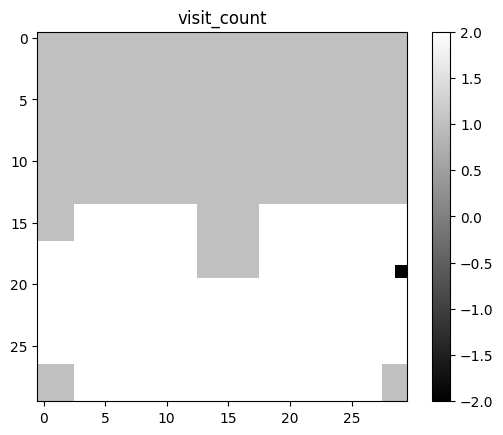

1/1 [==============================] - 0s 17ms/step
Ready to take action:3 with q_values:[[36.33496 35.49852 33.7529  37.17879]] after 0 changes
Collision! Car stays in the same position:  (19, 29)
Cells visited: 426/900 at time step: 66
Start training DQN model with batch size: 32

-------------------Time step: 67------------------------


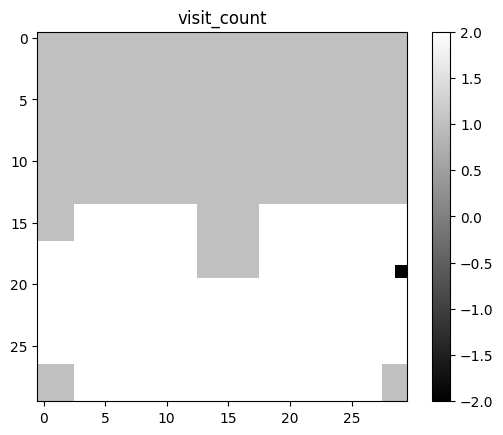

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[36.381016 34.93536  34.154728 37.90967 ]] after 1 changes
Collision! Car stays in the same position:  (19, 29)
Cells visited: 426/900 at time step: 67
Start training DQN model with batch size: 32

-------------------Time step: 68------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (19, 29)
Cells visited: 426/900 at time step: 68
Start training DQN model with batch size: 32

-------------------Time step: 69------------------------
Ready to take random action:2
Car moves Left 3 units from (19, 29) to (19, 26)
Cells visited: 426/900 at time step: 69
Start training DQN model with batch size: 32

-------------------Time step: 70------------------------
Ready to take random action:1
Car moves Down 3 units from (19, 26) to (22, 26)
Cells visited: 426/900 at time step: 70
Start training DQN model with batch size: 32

-------------------Time step: 71----------

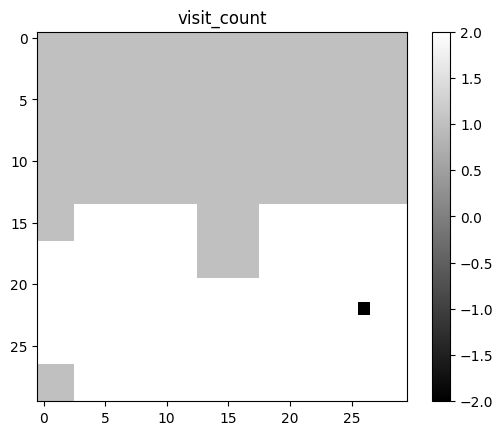

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[37.595768 36.29692  35.54002  36.778435]] after 0 changes
Car moves Up 3 units from (22, 26) to (19, 26)
Cells visited: 432/900 at time step: 73
Start training DQN model with batch size: 32

-------------------Time step: 74------------------------
Ready to take random action:1
Car moves Down 3 units from (19, 26) to (22, 26)
Cells visited: 432/900 at time step: 74
Start training DQN model with batch size: 32

-------------------Time step: 75------------------------


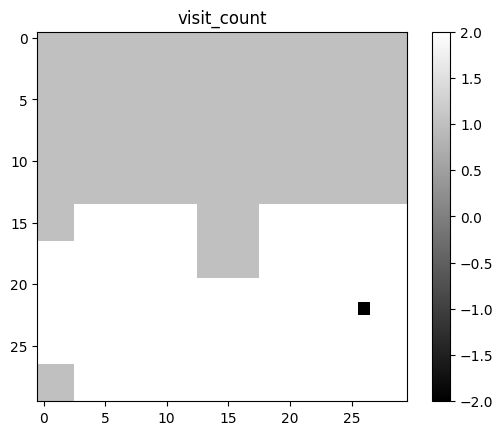

1/1 [==============================] - 0s 18ms/step
Ready to take action:0 with q_values:[[37.89075  34.8678   35.583946 37.717823]] after 0 changes
Car moves Up 3 units from (22, 26) to (19, 26)
Cells visited: 432/900 at time step: 75
Start training DQN model with batch size: 32

-------------------Time step: 76------------------------
Ready to take random action:3
Car moves Right 3 units from (19, 26) to (19, 29)
Cells visited: 432/900 at time step: 76
Start training DQN model with batch size: 32

-------------------Time step: 77------------------------
Ready to take random action:0
Car moves Up 3 units from (19, 29) to (16, 29)
Cells visited: 432/900 at time step: 77
Start training DQN model with batch size: 32

-------------------Time step: 78------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (16, 29)
Cells visited: 450/900 at time step: 78
Start training DQN model with batch size: 32

-------------------Time step: 79-----------------

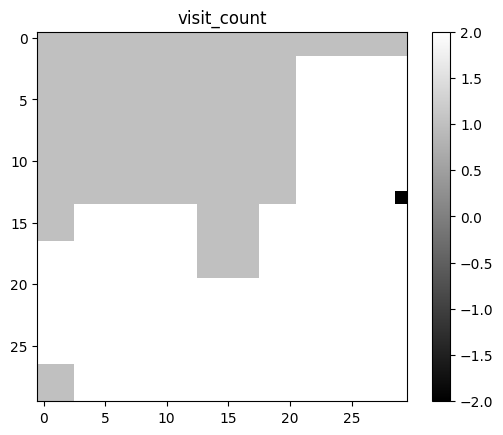

1/1 [==============================] - 0s 16ms/step
Ready to take action:0 with q_values:[[41.508247 37.887222 37.772713 38.330086]] after 0 changes
Car moves Up 3 units from (13, 29) to (10, 29)
Cells visited: 540/900 at time step: 87
Start training DQN model with batch size: 32

-------------------Time step: 88------------------------
Ready to take random action:3
Collision! Car stays in the same position:  (10, 29)
Cells visited: 540/900 at time step: 88
Start training DQN model with batch size: 32

-------------------Time step: 89------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 29) to (13, 29)
Cells visited: 540/900 at time step: 89
Start training DQN model with batch size: 32

-------------------Time step: 90------------------------


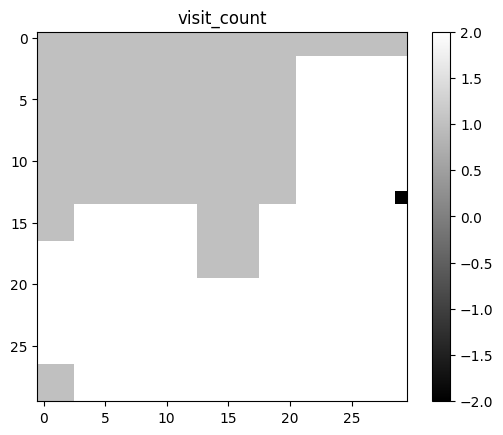

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[41.62712  38.067776 38.604652 40.163353]] after 0 changes
Car moves Up 3 units from (13, 29) to (10, 29)
Cells visited: 540/900 at time step: 90
Start training DQN model with batch size: 32

-------------------Time step: 91------------------------


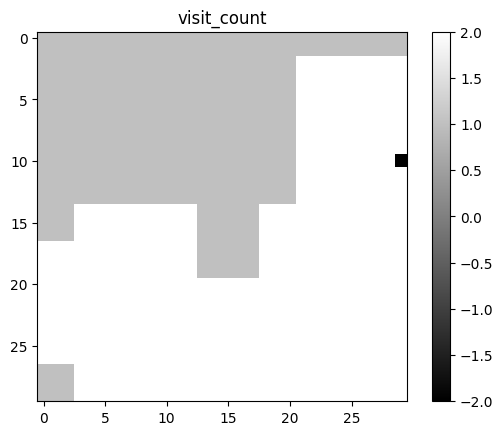

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[42.25436  39.083214 38.62934  40.948967]] after 0 changes
Car moves Up 3 units from (10, 29) to (7, 29)
Cells visited: 540/900 at time step: 91
Start training DQN model with batch size: 32

-------------------Time step: 92------------------------
Ready to take random action:2
Car moves Left 3 units from (7, 29) to (7, 26)
Cells visited: 540/900 at time step: 92
Start training DQN model with batch size: 32

-------------------Time step: 93------------------------
Ready to take random action:0
Car moves Up 3 units from (7, 26) to (4, 26)
Cells visited: 540/900 at time step: 93
Start training DQN model with batch size: 32

-------------------Time step: 94------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 26) to (4, 29)
Cells visited: 558/900 at time step: 94
Start training DQN model with batch size: 32

-------------------Time step: 95------------------------
Rea

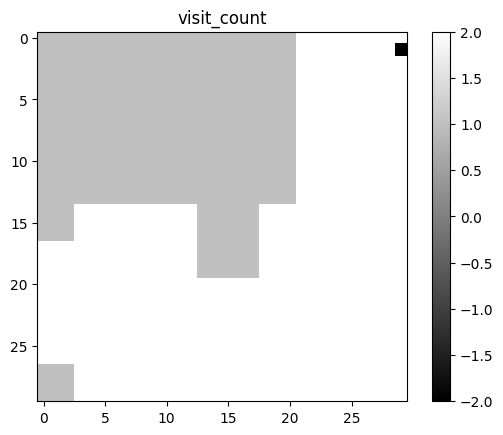

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[41.782837 41.707314 40.9204   41.807457]] after 0 changes
Collision! Car stays in the same position:  (1, 29)
Cells visited: 558/900 at time step: 100
Start training DQN model with batch size: 32


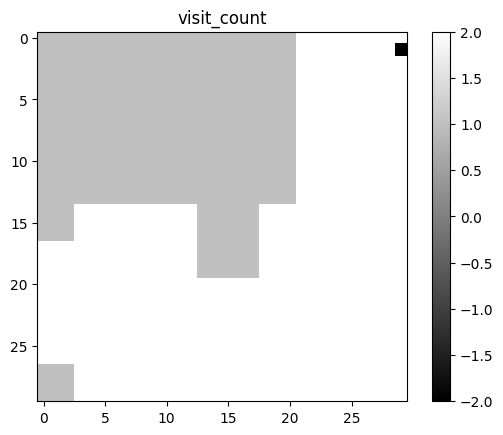

Model and replay buffer are saved under train_breakpoint at time step: 100

-------------------Time step: 101------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 29) to (4, 29)
Cells visited: 558/900 at time step: 101
Start training DQN model with batch size: 32

-------------------Time step: 102------------------------
Ready to take random action:1
Car moves Down 3 units from (4, 29) to (7, 29)
Cells visited: 558/900 at time step: 102
Start training DQN model with batch size: 32

-------------------Time step: 103------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 29) to (10, 29)
Cells visited: 558/900 at time step: 103
Start training DQN model with batch size: 32

-------------------Time step: 104------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 29) to (10, 26)
Cells visited: 558/900 at time step: 104
Start training DQN model with batch size: 32

-------------------Time step: 105

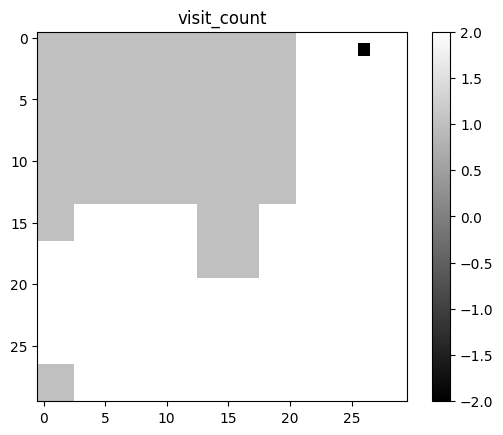

1/1 [==============================] - 0s 17ms/step
Ready to take action:0 with q_values:[[41.454674 39.408504 39.08634  39.64602 ]] after 1 changes
Collision! Car stays in the same position:  (1, 26)
Cells visited: 558/900 at time step: 115
Start training DQN model with batch size: 32

-------------------Time step: 116------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 558/900 at time step: 116
Start training DQN model with batch size: 32

-------------------Time step: 117------------------------


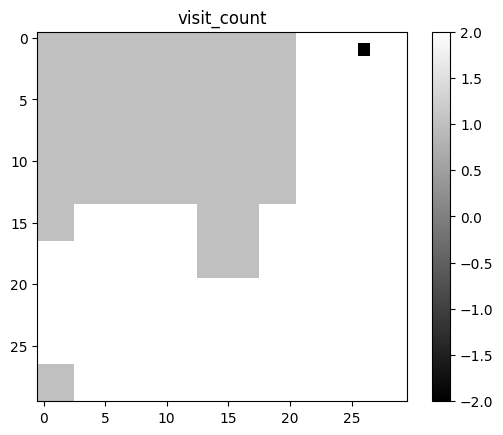

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[40.65641  39.667213 39.215183 39.94985 ]] after 3 changes
Collision! Car stays in the same position:  (1, 26)
Cells visited: 558/900 at time step: 117
Start training DQN model with batch size: 32

-------------------Time step: 118------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 558/900 at time step: 118
Start training DQN model with batch size: 32

-------------------Time step: 119------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 576/900 at time step: 119
Start training DQN model with batch size: 32

-------------------Time step: 120------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 20) to (4, 20)
Cells visited: 594/900 at time step: 120
Start training DQN model with batch size: 32

-------------------Time step: 121-------------

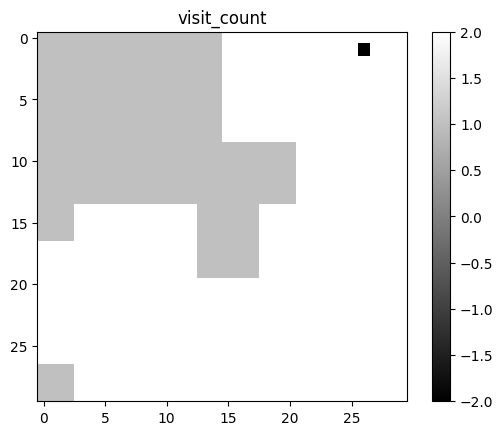

1/1 [==============================] - 0s 13ms/step
Ready to take action:0 with q_values:[[41.93169  40.014214 39.508415 38.632572]] after 0 changes
Collision! Car stays in the same position:  (1, 26)
Cells visited: 612/900 at time step: 124
Start training DQN model with batch size: 32

-------------------Time step: 125------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 26)
Cells visited: 612/900 at time step: 125
Start training DQN model with batch size: 32

-------------------Time step: 126------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 26) to (1, 29)
Cells visited: 612/900 at time step: 126
Start training DQN model with batch size: 32

-------------------Time step: 127------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 29)
Cells visited: 612/900 at time step: 127
Start training DQN model with batch size: 32

-------------------Time step: 128--

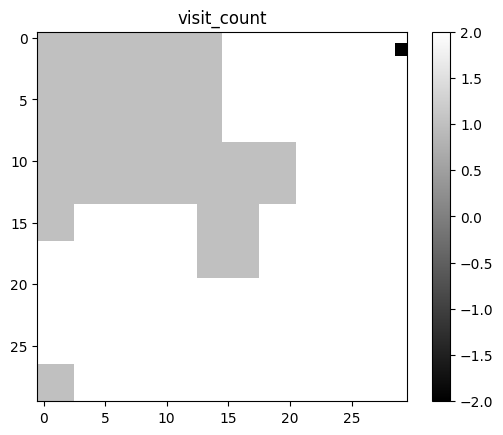

1/1 [==============================] - 0s 14ms/step
Ready to take action:2 with q_values:[[39.25824  38.87596  39.778122 38.161537]] after 2 changes
Car moves Left 3 units from (1, 29) to (1, 26)
Cells visited: 612/900 at time step: 133
Start training DQN model with batch size: 32

-------------------Time step: 134------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 612/900 at time step: 134
Start training DQN model with batch size: 32

-------------------Time step: 135------------------------


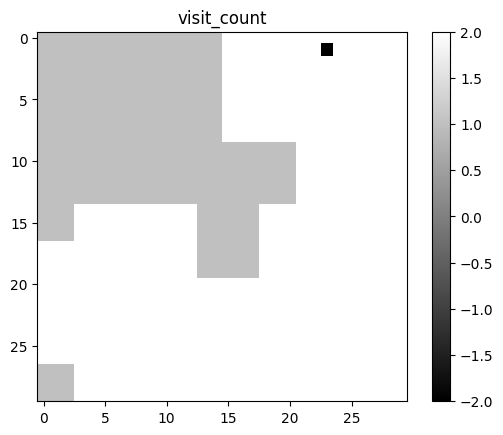

1/1 [==============================] - 0s 17ms/step
Ready to take action:0 with q_values:[[39.813404 39.21887  39.599583 38.705452]] after 0 changes
Collision! Car stays in the same position:  (1, 23)
Cells visited: 612/900 at time step: 135
Start training DQN model with batch size: 32

-------------------Time step: 136------------------------


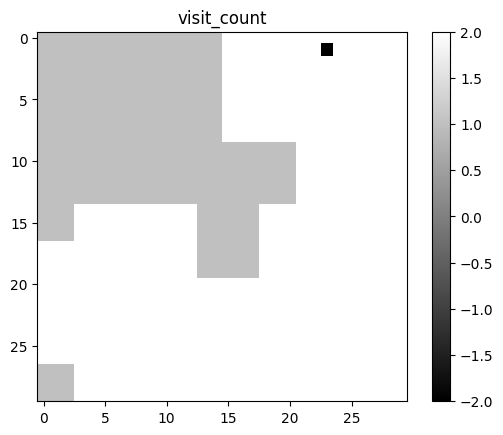

1/1 [==============================] - 0s 14ms/step
Ready to take action:2 with q_values:[[39.207912 39.274307 39.601845 38.53817 ]] after 1 changes
Car moves Left 3 units from (1, 23) to (1, 20)
Cells visited: 612/900 at time step: 136
Start training DQN model with batch size: 32

-------------------Time step: 137------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 20) to (1, 17)
Cells visited: 612/900 at time step: 137
Start training DQN model with batch size: 32

-------------------Time step: 138------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 17) to (4, 17)
Cells visited: 630/900 at time step: 138
Start training DQN model with batch size: 32

-------------------Time step: 139------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 17) to (1, 17)
Cells visited: 639/900 at time step: 139
Start training DQN model with batch size: 32

-------------------Time step: 140--------------------

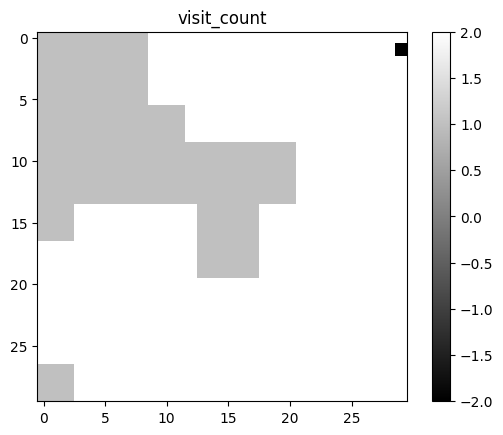

Model and replay buffer are saved under train_breakpoint at time step: 150

-------------------Time step: 151------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 29) to (1, 26)
Cells visited: 657/900 at time step: 151
Start training DQN model with batch size: 32

-------------------Time step: 152------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 26) to (1, 29)
Cells visited: 657/900 at time step: 152
Start training DQN model with batch size: 32

-------------------Time step: 153------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 29) to (1, 26)
Cells visited: 657/900 at time step: 153
Start training DQN model with batch size: 32

-------------------Time step: 154------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 26) to (1, 23)
Cells visited: 657/900 at time step: 154
Start training DQN model with batch size: 32

-------------------Time step: 155--

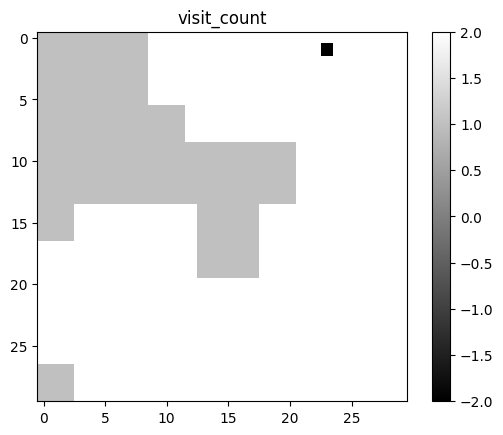

1/1 [==============================] - 0s 15ms/step
Ready to take action:0 with q_values:[[36.8704   36.464043 36.620583 36.16006 ]] after 0 changes
Collision! Car stays in the same position:  (1, 23)
Cells visited: 657/900 at time step: 155
Start training DQN model with batch size: 32

-------------------Time step: 156------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 23) to (4, 23)
Cells visited: 657/900 at time step: 156
Start training DQN model with batch size: 32

-------------------Time step: 157------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (4, 23)
Cells visited: 657/900 at time step: 157
Start training DQN model with batch size: 32

-------------------Time step: 158------------------------
Ready to take random action:2
Car moves Left 3 units from (4, 23) to (4, 20)
Cells visited: 657/900 at time step: 158
Start training DQN model with batch size: 32

-------------------Time step: 159--------

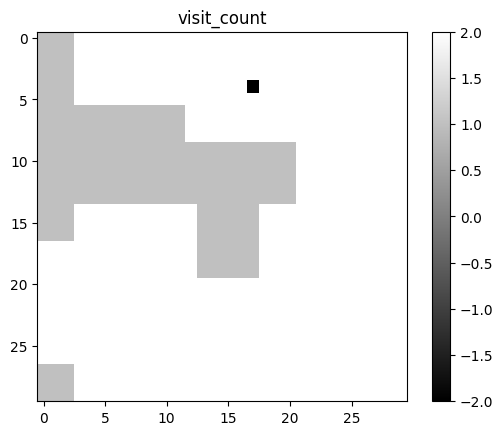

1/1 [==============================] - 0s 14ms/step
Ready to take action:2 with q_values:[[33.60495  35.061157 35.949654 34.247036]] after 1 changes
Collision! Car stays in the same position:  (4, 17)
Cells visited: 693/900 at time step: 183
Start training DQN model with batch size: 32

-------------------Time step: 184------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 17) to (1, 17)
Cells visited: 693/900 at time step: 184
Start training DQN model with batch size: 32

-------------------Time step: 185------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 17) to (4, 17)
Cells visited: 693/900 at time step: 185
Start training DQN model with batch size: 32

-------------------Time step: 186------------------------
Ready to take random action:3
Car moves Right 3 units from (4, 17) to (4, 20)
Cells visited: 693/900 at time step: 186
Start training DQN model with batch size: 32

-------------------Time step: 187--------------

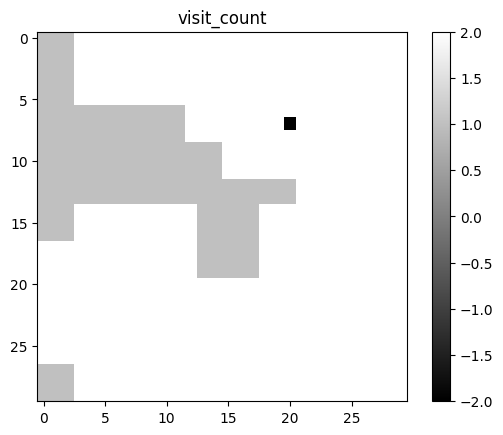

1/1 [==============================] - 0s 14ms/step
Ready to take action:1 with q_values:[[31.401342 32.431892 32.07376  30.866417]] after 2 changes
Car moves Down 3 units from (7, 20) to (10, 20)
Cells visited: 711/900 at time step: 198
Start training DQN model with batch size: 32

-------------------Time step: 199------------------------
Ready to take random action:2
Car moves Left 3 units from (10, 20) to (10, 17)
Cells visited: 726/900 at time step: 199
Start training DQN model with batch size: 32

-------------------Time step: 200------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 17) to (10, 20)
Cells visited: 743/900 at time step: 200
Start training DQN model with batch size: 32


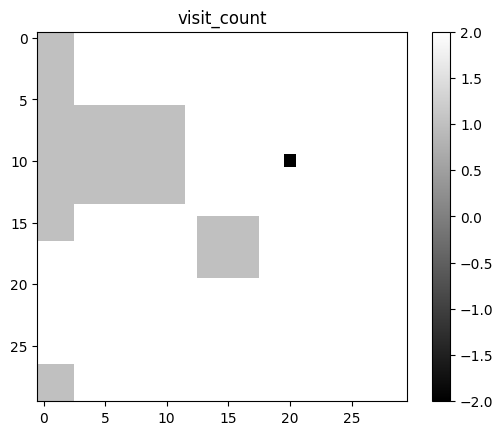

Model and replay buffer are saved under train_breakpoint at time step: 200

-------------------Time step: 201------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 20) to (13, 20)
Cells visited: 743/900 at time step: 201
Start training DQN model with batch size: 32

-------------------Time step: 202------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 20) to (10, 20)
Cells visited: 752/900 at time step: 202
Start training DQN model with batch size: 32

-------------------Time step: 203------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 20) to (10, 23)
Cells visited: 752/900 at time step: 203
Start training DQN model with batch size: 32

-------------------Time step: 204------------------------
Ready to take random action:1
Car moves Down 3 units from (10, 23) to (13, 23)
Cells visited: 752/900 at time step: 204
Start training DQN model with batch size: 32

-------------------Time step:

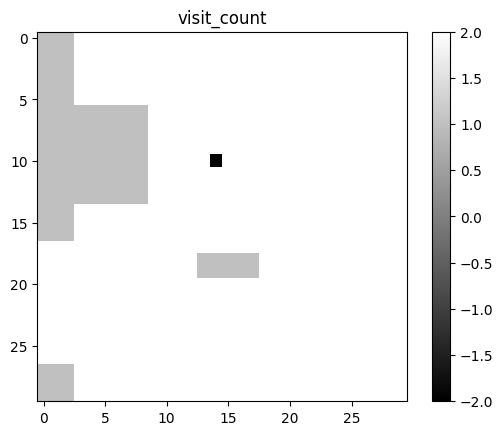

1/1 [==============================] - 0s 14ms/step
Ready to take action:2 with q_values:[[29.547638 31.080751 31.41945  30.04734 ]] after 0 changes
Car moves Left 3 units from (10, 14) to (10, 11)
Cells visited: 782/900 at time step: 213
Start training DQN model with batch size: 32

-------------------Time step: 214------------------------


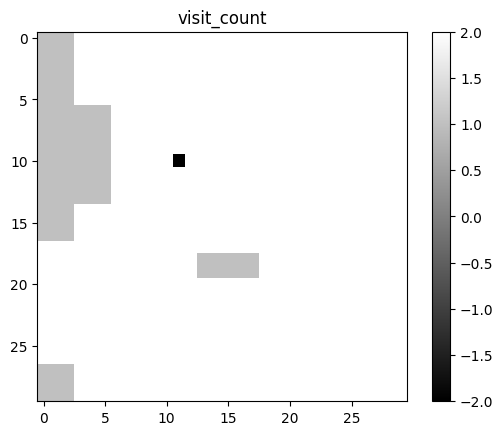

1/1 [==============================] - 0s 14ms/step
Ready to take action:1 with q_values:[[29.880081 31.033613 30.927448 30.246702]] after 0 changes
Car moves Down 3 units from (10, 11) to (13, 11)
Cells visited: 806/900 at time step: 214
Start training DQN model with batch size: 32

-------------------Time step: 215------------------------
Ready to take random action:1
Collision! Car stays in the same position:  (13, 11)
Cells visited: 806/900 at time step: 215
Start training DQN model with batch size: 32

-------------------Time step: 216------------------------
Ready to take random action:0
Car moves Up 3 units from (13, 11) to (10, 11)
Cells visited: 806/900 at time step: 216
Start training DQN model with batch size: 32

-------------------Time step: 217------------------------
Ready to take random action:3
Car moves Right 3 units from (10, 11) to (10, 14)
Cells visited: 806/900 at time step: 217
Start training DQN model with batch size: 32

-------------------Time step: 218-------

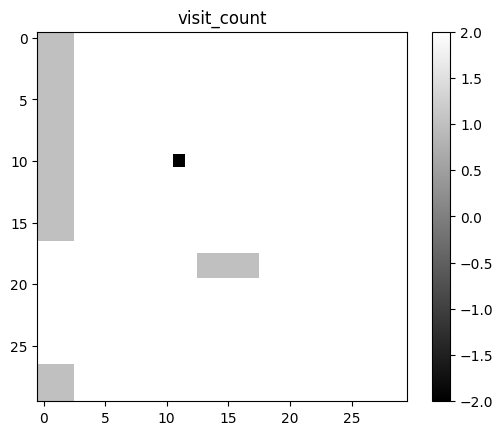

1/1 [==============================] - 0s 14ms/step
Ready to take action:0 with q_values:[[31.21956  29.746317 30.085497 30.64734 ]] after 0 changes
Car moves Up 3 units from (10, 11) to (7, 11)
Cells visited: 830/900 at time step: 228
Start training DQN model with batch size: 32

-------------------Time step: 229------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 11) to (10, 11)
Cells visited: 830/900 at time step: 229
Start training DQN model with batch size: 32

-------------------Time step: 230------------------------
Ready to take random action:0
Car moves Up 3 units from (10, 11) to (7, 11)
Cells visited: 830/900 at time step: 230
Start training DQN model with batch size: 32

-------------------Time step: 231------------------------
Ready to take random action:2
Car moves Left 3 units from (7, 11) to (7, 8)
Cells visited: 830/900 at time step: 231
Start training DQN model with batch size: 32

-------------------Time step: 232--------------------

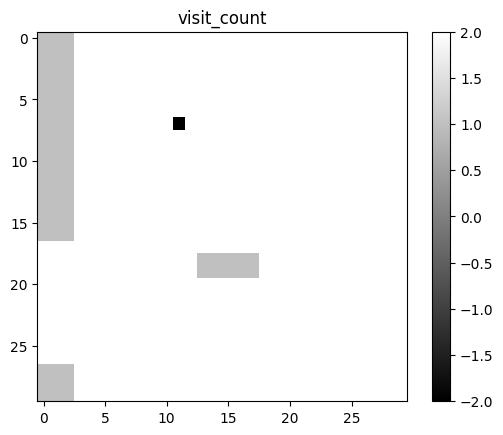

1/1 [==============================] - 0s 14ms/step
Ready to take action:3 with q_values:[[29.062487 30.158426 30.61544  30.747416]] after 0 changes
Car moves Right 3 units from (7, 11) to (7, 14)
Cells visited: 830/900 at time step: 233
Start training DQN model with batch size: 32

-------------------Time step: 234------------------------
Ready to take random action:2
Car moves Left 3 units from (7, 14) to (7, 11)
Cells visited: 830/900 at time step: 234
Start training DQN model with batch size: 32

-------------------Time step: 235------------------------


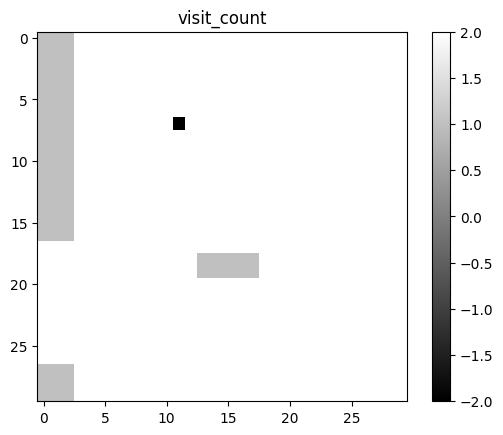

1/1 [==============================] - 0s 16ms/step
Ready to take action:2 with q_values:[[29.779772 30.174086 30.210611 30.142908]] after 0 changes
Car moves Left 3 units from (7, 11) to (7, 8)
Cells visited: 830/900 at time step: 235
Start training DQN model with batch size: 32

-------------------Time step: 236------------------------
Ready to take random action:1
Car moves Down 3 units from (7, 8) to (10, 8)
Cells visited: 830/900 at time step: 236
Start training DQN model with batch size: 32

-------------------Time step: 237------------------------
Ready to take random action:2
Collision! Car stays in the same position:  (10, 8)
Cells visited: 830/900 at time step: 237
Start training DQN model with batch size: 32

-------------------Time step: 238------------------------
Ready to take random action:0
Car moves Up 3 units from (10, 8) to (7, 8)
Cells visited: 830/900 at time step: 238
Start training DQN model with batch size: 32

-------------------Time step: 239------------------

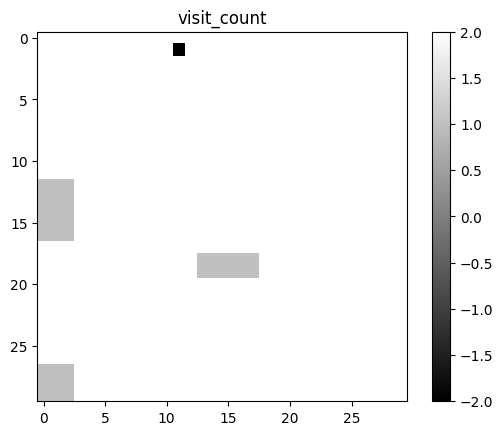

1/1 [==============================] - 0s 19ms/step
Ready to take action:2 with q_values:[[28.80495  28.223473 29.066044 28.542854]] after 1 changes
Car moves Left 3 units from (1, 11) to (1, 8)
Cells visited: 866/900 at time step: 248
Start training DQN model with batch size: 32

-------------------Time step: 249------------------------
Ready to take random action:0
Collision! Car stays in the same position:  (1, 8)
Cells visited: 866/900 at time step: 249
Start training DQN model with batch size: 32

-------------------Time step: 250------------------------
Ready to take random action:1
Car moves Down 3 units from (1, 8) to (4, 8)
Cells visited: 866/900 at time step: 250
Start training DQN model with batch size: 32


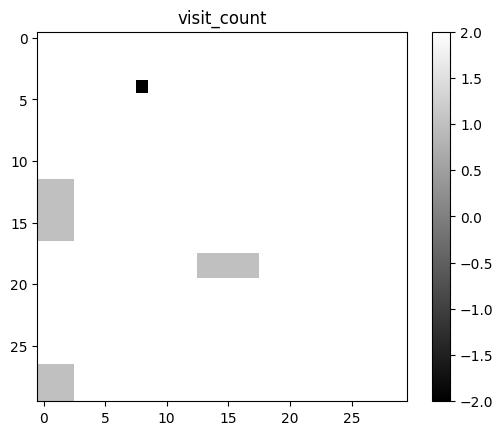

Model and replay buffer are saved under train_breakpoint at time step: 250

-------------------Time step: 251------------------------
Ready to take random action:0
Car moves Up 3 units from (4, 8) to (1, 8)
Cells visited: 866/900 at time step: 251
Start training DQN model with batch size: 32

-------------------Time step: 252------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 8) to (1, 5)
Cells visited: 866/900 at time step: 252
Start training DQN model with batch size: 32

-------------------Time step: 253------------------------
Ready to take random action:2
Car moves Left 3 units from (1, 5) to (1, 2)
Cells visited: 866/900 at time step: 253
Start training DQN model with batch size: 32

-------------------Time step: 254------------------------
Ready to take random action:3
Car moves Right 3 units from (1, 2) to (1, 5)
Cells visited: 866/900 at time step: 254
Start training DQN model with batch size: 32

-------------------Time step: 255------------

In [ ]:
if train_mode != 'test':
    for episode in range(n_episodes): # 训练多少张图
        print(f"\n********************Episode: {episode+1}/{n_episodes}********************")

        # Reset the environment and get the initial state
        state = env.state if train_mode== 'train_from_breakpoint' else env.reset()
        state,_ = prepare_state(state)
        epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min
        replay_buffer = deque(maxlen=2000)
        CHANGE_ACTION_FLAG = 0

        # Loop through each time step
        for time_step in range(time_steps): 
            print(f"\n-------------------Time step: {time_step}------------------------")

            # In each time step, agent selects an action and implement it, environment provides feedback
            action = select_action(state, epsilon, CHANGE_ACTION_FLAG)
            next_state, reward, done, _ = env.step(action)
    #         print(f"Reward after this action:{reward}")
            if done or time_step>300:
                env.render(map_type="visit_count")
                print("This eqisode is done, ready for next one.")
                break
            cells_visited = state[0][state[0] == EXPLORED].shape[0] # 计算已经访问的cell数量
            cells = env.map_size[0]*env.map_size[1]
            print(f"Cells visited: {cells_visited}/{env.map_size[0]*env.map_size[1]} at time step: {time_step}")

            # Store the data into replay buffer
            next_state,_ = prepare_state(next_state)
            CHANGE_ACTION_FLAG = CHANGE_ACTION_FLAG + 1 if env.COLLISION_FLAG else 0
            replay_buffer.append((state, action, reward, next_state, done)) # 将数据存入replay buffer

            # Update state
            state = next_state

            # Train the model when replay buffer is larger than batch size
            if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
                print(f"Start training DQN model with batch size: {batch_size}")
                losses = train_dqn(batch_size)

                # If we are in train mode, save the gym, model and replay buffer for emergency stop every 100 time steps
                if (train_mode == 'train' or train_mode == 'fine_tune') and time_step % 50 == 0:
                    env.render(map_type="visit_count")
                    save_breakpoint()
                    print(f"Model and replay buffer are saved under {breakpoint_path} at time step: {time_step}")

            # Otherwise, keep adding data to replay buffer
            else:
                print(f"Still adding data to replay buffer. Current replay buffer length: {len(replay_buffer)}")


In [ ]:
# test the dqn_model.h5
if train_mode == 'test':
    tested_model = tf.keras.models.load_model(model_path)
    state = env.reset()
    state,_ = prepare_state(state)
    time_step = 0
    while True:
        print(f"\n-------------------Time step: {time_step}------------------------")
        print(tested_model.predict(state)[0])
        action = np.argmax(tested_model.predict(state)[0])
        print(f"try action:{action}")
        next_state, reward, done, _ = env.step(action)
        if env.COLLISION_FLAG == True:
            action = random.randrange(action_size)
            next_state, reward, done, _ = env.step(action)
        if done:
            env.render(map_type="visit_count")
            print("This eqisode is done, ready for next one.")
            break
        if time_step % 100 == 0:
            env.render()
        next_state,_ = prepare_state(next_state)
        state = next_state
        time_step += 1